# Music Genre Classification

### Task:
Develop machine learning algorithms that can predict a music genre for each sample, using the data music.csv

### Business goal:
To make the prediction for the music genre dataset; minimising error and maximising accurate classification. 

### Data used:
This dataset is an adapted version of a publicly available resource, which can be accessed at: [GTZAN Dataset on Kaggle.](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/dat)

It contains:

CSV files (2) - Each file contains features of audio files. The first file, **features_30_sec.csv**, contains a mean and variance for multiple attributes extracted from 30-seconds-long samples of audio files. The second file, **features_3_sec.csv**, contains 10 times more data, due to each each song being split into 3 seconds samples. 

For the purpose of this project, I will refer to the features_30_sec.csv as **30s data** and, conversely, **3s data** to the features_3_s.csv dataset.  

Mel Spectrograms - A visual representation for each audio file that could be used in NNs.

An original GTZAN dataset collection of 100 audio files for each genre (10).

### Research Question:

**Q1.** Is model trained on '3s data' performing better than the same model trained on '30s data'? In other words, does splitting the 30 seconds samples into smaller 3 seconds samples, before computing the mean and variance for each feature (hence increasing the overall number of data almost 10-folds) increase the accuaracy of the classifier and minimise error? 

**Q2.** Is combining features from both datasets improving the model performance as opposed to using features from single datasets solely? 

**Q3** Does a larger set of selected features (5 and 9) lead to a better performance? 

### Tools:

In [1]:
# Libraries necessary for the project:

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, cross_val_predict, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve  
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier


# from sklearn.preprocessing import OneHotEncoder

# Hide warnings
warnings.filterwarnings('ignore')
# Define seed value to conduct the experiments in a controled environment
seed = 42
np.random.seed(seed)

In [2]:
# Custom function for checking assumptions for Wilcoxon signed-rank test

def check_wilcoxon_assumptions(scores_a, scores_b, model_name=""):
    """
    This function checks assumptions for Wilcoxon signed-rank test.
    
    Parameters:
    scores_a: CV RMSE scores for original (untrimmed) dataset
    scores_b: CV RMSE scores for transformed (trimmed) dataset
    model_name: name of the tested (and plotted) model
    """
    
    # Calculate differences between paired observations
    differences = scores_a - scores_b
    
    # Check if all observations (scores) are paired, i.e., of equal length
    print(f"*****Checking assumptions for {model_name}*****")
    print(f"Number of observations in sample A: {len(scores_a)}")
    print(f"Number of observations in sample B: {len(scores_b)}")
    
    # Check if differences are continuous (do they have decimal places)
    print(f"\nDifferences are continuous: {np.any(differences % 1 != 0)}")
    
    # Check if distribution of differences is symetrical in shape using Shapiro-Wilk test
    _, p_value = shapiro(differences)
    print(f"\nShapiro-Wilk test for normality of differences:")
    print(f"p-value: {p_value}")
    if p_value > 0.05:
        print('\nThe distribution of differences in scores is symmetrical in shape')
    else:
        print('\nThe distribution of differences in scores is NOT symmetrical in shape') 
    
    # return differences

In [153]:
# Custom function for sampling 10 random indices from a given y subset, where each row represents a unique genre in the music dataset. 
def get_samples_indicises(y_subset):
    """ Get indices for 10 random rows from the the music datset. 
    The function returns indices for rows from the given y_train set where all values (genres) are unique."""
    
    sampled_rows = y_train.sample(n=100, random_state=seed, replace=False).sort_values()

    # helper variables
    seen = []
    to_drop = []
    
    for i, genre in enumerate(sampled_rows):
        if genre not in seen:
            seen.append(genre) # if music genre is seen for the firts time
        else:
            to_drop.append(sampled_rows.index[i]) # drop if repeated genre
    
    sampled_rows = sampled_rows.drop(index=to_drop)

    return sampled_rows.index

### Importing Data:

In [3]:
# I import both datasets to compare them
data_30s = pd.read_csv("../Data/music/features_30_sec.csv")
data_3s = pd.read_csv("../Data/music/features_3_sec.csv")

### Quick look at the data structure:

In [4]:
# Display all columns in the datasets
pd.set_option('display.max_columns', None)

data_30s.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  rolloff_mean  \
0              2002.449060            85882.761315   3805.839606   
1              2039.036516           213843.755497   3550.522098   
2              1747.702312            76254.192257   3042.260232   
3              1596.412872           166441.494769   2184.745799   
4              1748.172116            88445.209036   3579.757627   

    rolloff_var  zero_crossing_rate_mean  zero_crossing_rate_var  \
0  9.015054e+05                 0.083045                0.000767   
1  2.977893e+06                 0.056040                0.001448   
2  7.840345e+05                 0.076291                0.001007   
3  1.493194e+06                 0.033309                0.000423   
4  1.572978e+06                 0.101461                0.001954   

   harmony_mean  harmony_var  perceptr_mean  perceptr_var       tempo  \
0 -4.529724e-05     0.008172       0.000008      0.005698  123.046875   
1  1.395807e-04     0.005099      -0.000178      0.003063   67.999589   
2  2.105576e-06     0.016342      -0.000019      0.007458  161.499023   
3  4.583644e-07     0.019054      -0.000014      0.002712   63.024009   
4 -1.756129e-05     0.004814      -0.000010      0.003094  135.999178   

   mfcc1_mean    mfcc1_var  mfcc2_mean   mfcc2_var  mfcc3_mean   mfcc3_var  \
0 -113.570648  2564.207520  121.571793  295.913818  -19.168142  235.574432   
1 -207.501694  7764.555176  123.991264  560.259949    8.955127  572.810913   
2  -90.722595  3319.044922  140.446304  508.765045  -29.093889  411.781219   
3 -199.544205  5507.517090  150.090897  456.505402    5.662678  257.161163   
4 -160.337708  5195.291992  126.219635  853.784729  -35.587811  333.792938   

   mfcc4_mean   mfcc4_var  mfcc5_mean   mfcc5_var  mfcc6_mean   mfcc6_var  \
0   42.366421  151.106873   -6.364664  167.934799   18.623499   89.180840   
1   35.877647  264.506104    2.907320  279.932922   21.510466  156.477097   
2   31.684334  144.090317  -13.984504  155.493759   25.764742   74.548401   
3   26.859079  158.267303    1.771399  268.034393   14.234031  126.794128   
4   22.148071  193.456100  -32.478600  336.276825   10.852294  134.831573   

   mfcc7_mean   mfcc7_var  mfcc8_mean   mfcc8_var  mfcc9_mean   mfcc9_var  \
0  -13.704891   67.660492   15.343150   68.932579  -12.274110   82.204201   
1   -8.560436  200.849182   23.370686  142.555954  -10.099661  166.108521   
2  -13.664875  106.981827   11.639934  106.574875  -11.783643   65.447945   
3   -4.832006  155.912079    9.286494   81.273743   -0.759186   92.114090   
4  -23.352329   93.257095    0.498434  124.672127  -11.793437  130.073349   

   mfcc10_mean  mfcc10_var  mfcc11_mean  mfcc11_var  mfcc12_mean  mfcc12_var  \
0    10.976572   63.386311    -8.326573   61.773094     8.803792   51.244125   
1    11.900497  104.358612    -5.555639  105.173630     5.376327   96.197212   
2     9.718760   67.908859   -13.133803   57.781425     5.791199   64.480209   
3     8.137607   71.314079    -3.200653  110.236687     6.079319   48.251999   
4     1.207256   99.675575   -13.088418   80.254066    -2.813867   86.430626   

   mfcc13_mean  mfcc13_var  mfcc14_mean  mfcc14_var  

Initial look at the '30s data' data reveals there are 60 columns (including the label), with 1000 entries (rows) of data. There don't appear to be any missing values. Regarding the data type of attributes, almost all of them hold numerical values (float64 and int64) apart from the 'filename' and 'label' columns which hold strings. 

In [5]:
data_30s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [6]:
data_3s.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  rolloff_mean  \
0              1972.744388           117335.771563   3714.560359   
1              2010.051501            65671.875673   3869.682242   
2              2084.565132            75124.921716   3997.639160   
3              1960.039988            82913.639269   3568.300218   
4              1948.503884            60204.020268   3469.992864   

    rolloff_var  zero_crossing_rate_mean  zero_crossing_rate_var  \
0  1.080790e+06                 0.081851                0.000558   
1  6.722448e+05                 0.087173                0.001030   
2  7.907127e+05                 0.071383                0.000425   
3  9.216524e+05                 0.069426                0.000304   
4  6.102111e+05                 0.070095                0.000289   

   harmony_mean  harmony_var  perceptr_mean  perceptr_var       tempo  \
0     -0.000078     0.008354      -0.000068      0.005535  129.199219   
1     -0.000099     0.004950      -0.000103      0.004854  123.046875   
2     -0.000066     0.012476       0.000065      0.004357  123.046875   
3     -0.000014     0.008318       0.000018      0.005927  123.046875   
4      0.000041     0.009634      -0.000106      0.005833  123.046875   

   mfcc1_mean    mfcc1_var  mfcc2_mean   mfcc2_var  mfcc3_mean   mfcc3_var  \
0 -118.627914  2440.286621  125.083626  260.956909  -23.443724  364.081726   
1 -125.590706  2038.344238  122.421227  216.774185  -20.718019  231.979767   
2 -132.441940  3798.532227  115.085175  257.321289  -14.811666  192.448074   
3 -118.231087  2508.781006  132.116501  332.650574  -18.758335  109.357529   
4 -105.968376  2118.919922  134.643646  219.562622  -19.961748  171.878754   

   mfcc4_mean   mfcc4_var  mfcc5_mean   mfcc5_var  mfcc6_mean   mfcc6_var  \
0   41.321484  181.694855   -5.976108  152.963135   20.115141   75.652298   
1   50.128387  142.700409  -11.333302  139.243118   21.385401   77.817947   
2   50.189293  144.166031   -0.680819  128.376892   24.650375   66.371170   
3   39.769306  184.693344  -13.260426  144.398224   20.468134  122.516464   
4   40.171753  103.120712  -14.271939  102.651230   18.734617   79.070000   

   mfcc7_mean  mfcc7_var  mfcc8_mean  mfcc8_var  mfcc9_mean   mfcc9_var  \
0  -16.045410  40.227104   17.855198  84.320282  -14.633434   83.437233   
1  -15.960796  97.364029   19.454103  57.948093  -12.465918   68.271523   
2  -13.506104  89.319336   15.643386  55.253967  -13.216637  120.308784   
3  -14.563448  68.937332   18.745104  74.748886  -13.755463   73.868576   
4  -15.619381  48.510284   19.207966  53.642956  -18.274683   95.300995   

   mfcc10_mean  mfcc10_var  mfcc11_mean  mfcc11_var  mfcc12_mean  mfcc12_var  \
0    10.270527   97.001335    -9.708279   66.669891    10.183875   45.103611   
1    17.898169   56.222176   -11.732554   54.373909     8.145000   40.662876   
2    10.406025   35.757862    -7.991465   47.911613    11.853963   36.569931   
3    12.993759   41.549564   -12.648887   58.540478    10.389314   39.102024   
4    14.316693   58.821163    -5.792194   55.030254    17.045437   43.229939   

   mfcc13_mean  mfcc13_var  mfcc14_mean  mfcc14_var  mf

When looking at the '3s data' I can see that the only structural difference from the '30s data' is in the number of entries (9990 as opposed to 1000), with the same number of features and data types.

In [7]:
data_3s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [8]:
# Capture the column names for both datasets 

data_30s_columns = data_30s.columns
data_3s_columns = data_3s.columns

# Compare if both datasets have the same columns 
print(f"\nBoth datasets have the same columns: {all(data_30s_columns == data_3s_columns)}\n")


Both datasets have the same columns: True



Considering my research question (Q1), I decide to work on the '3s data' first.

### Exploratory Data Analysis (EDA) 

Summary statistics reveals that the dataset contains values quite wide spread in terms of magnitude for each column. This means that scaling will be necessary at a later stage. 

In [9]:
data_3s.describe()

length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9990.0       9990.000000      9990.000000  9990.000000  9.990000e+03   
mean   66149.0          0.379534         0.084876     0.130859  2.676388e-03   
std        0.0          0.090466         0.009637     0.068545  3.585628e-03   
min    66149.0          0.107108         0.015345     0.000953  4.379535e-08   
25%    66149.0          0.315698         0.079833     0.083782  6.145900e-04   
50%    66149.0          0.384741         0.085108     0.121253  1.491318e-03   
75%    66149.0          0.442443         0.091092     0.176328  3.130862e-03   
max    66149.0          0.749481         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000           9.990000e+03              9990.000000   
mean              2199.219431           4.166727e+05              2241.385959   
std                751.860611           4.349644e+05               543.854449   
min                472.741636           8.118813e+02               499.162910   
25%               1630.680158           1.231961e+05              1887.455790   
50%               2208.628236           2.650692e+05              2230.575595   
75%               2712.581884           5.624152e+05              2588.340505   
max               5432.534406           4.794119e+06              3708.147554   

       spectral_bandwidth_var  rolloff_mean   rolloff_var  \
count            9.990000e+03   9990.000000  9.990000e+03   
mean             1.182711e+05   4566.076592  1.628790e+06   
std              1.013505e+05   1642.065335  1.489398e+06   
min              1.183520e+03    658.336276  1.145102e+03   
25%              4.876553e+04   3378.311110  5.595514e+05   
50%              8.996072e+04   4631.377892  1.160080e+06   
75%              1.585674e+05   5591.634521  2.262437e+06   
max              1.235143e+06   9487.446477  1.298320e+07   

       zero_crossing_rate_mean  zero_crossing_rate_var  harmony_mean  \
count              9990.000000             9990.000000   9990.000000   
mean                  0.102578                0.002620     -0.000365   
std                   0.045651                0.003614      0.001699   
min                   0.013525                0.000005     -0.026672   
25%                   0.067290                0.000628     -0.000127   
50%                   0.097868                0.001390     -0.000013   
75%                   0.132749                0.003058      0.000015   
max                   0.347705                0.065185      0.015688   

        harmony_var  perceptr_mean  perceptr_var        tempo   mfcc1_mean  \
count  9.990000e+03    9990.000000  9.990000e+03  9990.000000  9990.000000   
mean   1.259757e-02      -0.000396  5.601553e-03   124.887709  -145.424643   
std    1.263324e-02       0.001108  6.653225e-03    32.911676   106.456350   
min    9.312309e-23      -0.008794  4.672045e-08    24.377211  -662.171631   
25%    4.086402e-03      -0.000579  1.106077e-03   103.359375  -201.474651   
50%    8.429785e-03      -0.000056  3.347087e-03   123.046875  -120.118343   
75%    1.730287e-02       0.000020  7.520135e-03   143.554688   -69.897551   
max    1.270515e-01       0.006819  5.887909e-02   287.109375   107.941315   

          mfcc1_var   mfcc2_mean    mfcc2_var   mfcc3_mean    mfcc3_var  \
count   9990.000000  9990.000000  9990.000000  9990.000000  9990.000000   
mean    2808.904199   100.988234   588.795354    -9.995014   374.137619   
std     2596.256821    34.673178   459.705227    23.972522   294.470578   
min       25.190538   -12.053392     9.665931  -104.249832     2.055229   
25%     1143.226685    76.043871   270.420326   -26.884581   174.570415   
50%     2107.208008    98.618740   464.955734   -11.633667   296.598770   
75%     3693.259583   122.263046   773.292450     5.944046   487.393051   
max    45027.375000   251.212494  5131.987305    80.845

The **target class (label)** in the ML training will be the 'label' column, so I check if the data for all music genres is balanced and the answer is yes, the number of entries for all genres is nearly identical. 


Labels count in data_3s:

label
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: count, dtype: int64

Labels count in data_30s:

label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64


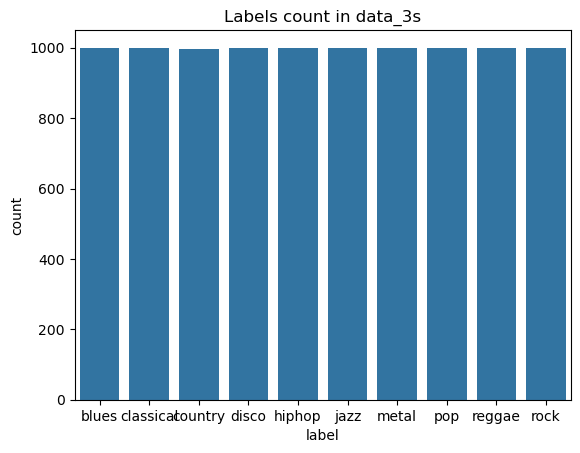

In [10]:
# Check if both datasets are balanced
labels_count_3s = data_3s['label'].value_counts()
print("\nLabels count in data_3s:\n")
print(labels_count_3s)

labels_count_30s = data_30s['label'].value_counts()
print("\nLabels count in data_30s:\n")
print(labels_count_30s)

sns.countplot(data_3s, x='label')
plt.title("Labels count in data_3s")
plt.show()

I drop the first two columns ('filename', 'length') as they won't be needed for now.

In [11]:
data_3s_v1 = data_3s.iloc[:,2:]
data_30s_v1 = data_30s.iloc[:,2:]

In [12]:
# missing values in the datasets?

null_3s = data_3s_v1[data_3s_v1.isnull().any(axis=1)].shape[0]
null_30s = data_30s_v1[data_30s_v1.isnull().any(axis=1)].shape[0]

print(f"\nRows with missing values in data_3s: {null_3s}\nRows with missing values in data_30s: {null_30s}\n")


Rows with missing values in data_3s: 0
Rows with missing values in data_30s: 0



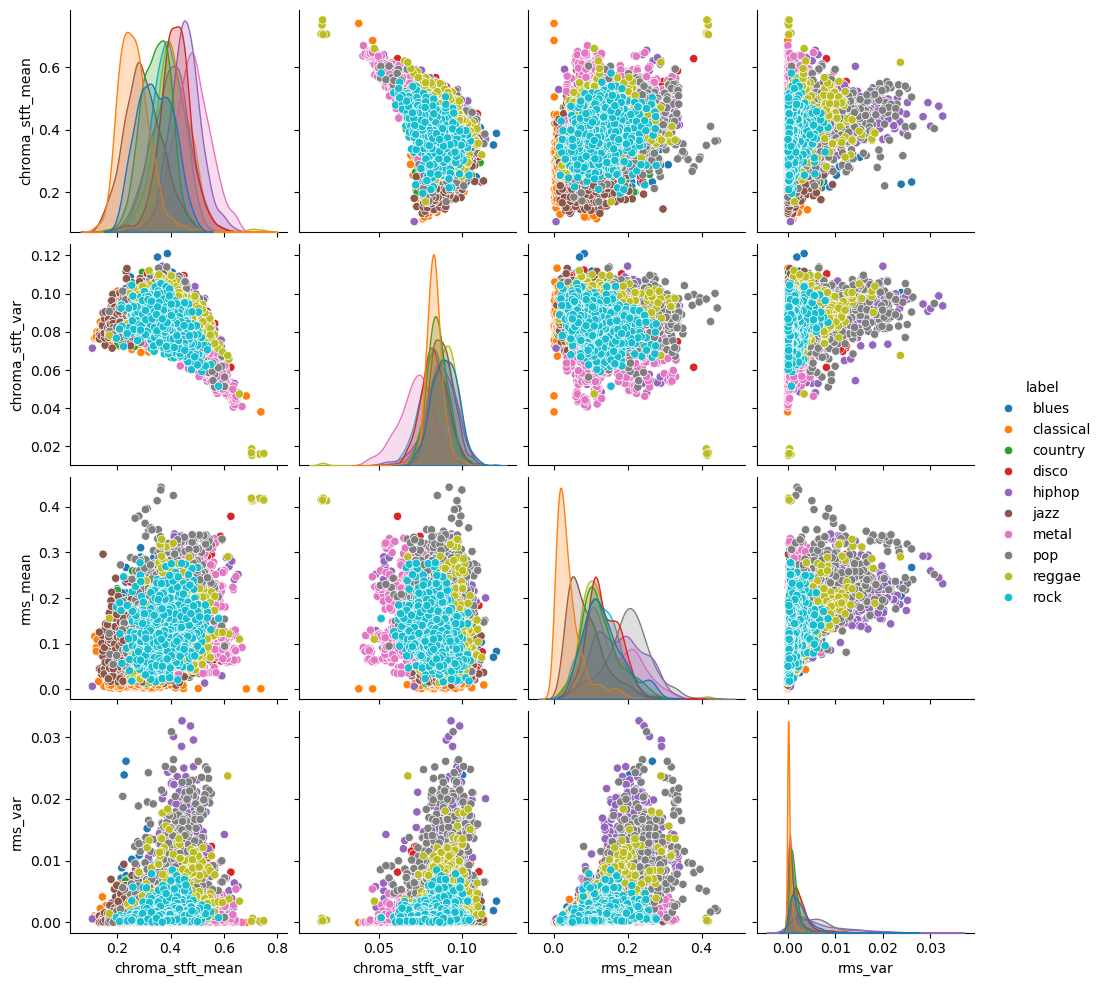

In [13]:
# the total number of features makes visualisation of variables impractical
# I will select the most promisinf features and then visualise them 
# only plotting the first 4 features at this stage to get the general insight into the dataset

feature_taster = data_3s.columns[2:6].union(['label'])

sns.pairplot(
    data=data_3s[feature_taster], 
    hue='label'
)
plt.show()

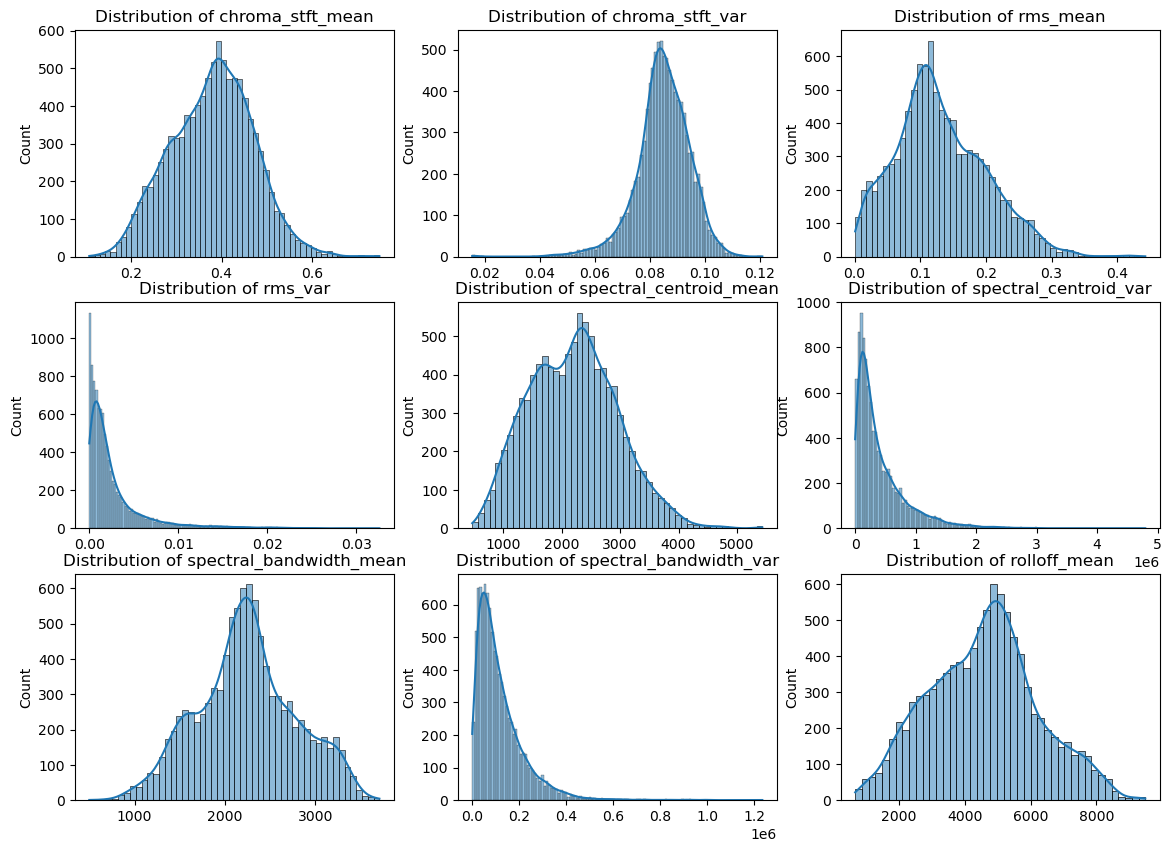

In [14]:
# print histograms for the first 9 features to gain more 
# insight about the spread of their values

# print histograms for the first 9 features
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.ravel()
for i, feature in enumerate(data_3s_v1.columns[:9]):
    sns.histplot(data=data_3s_v1, x=feature, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')

plt.show()

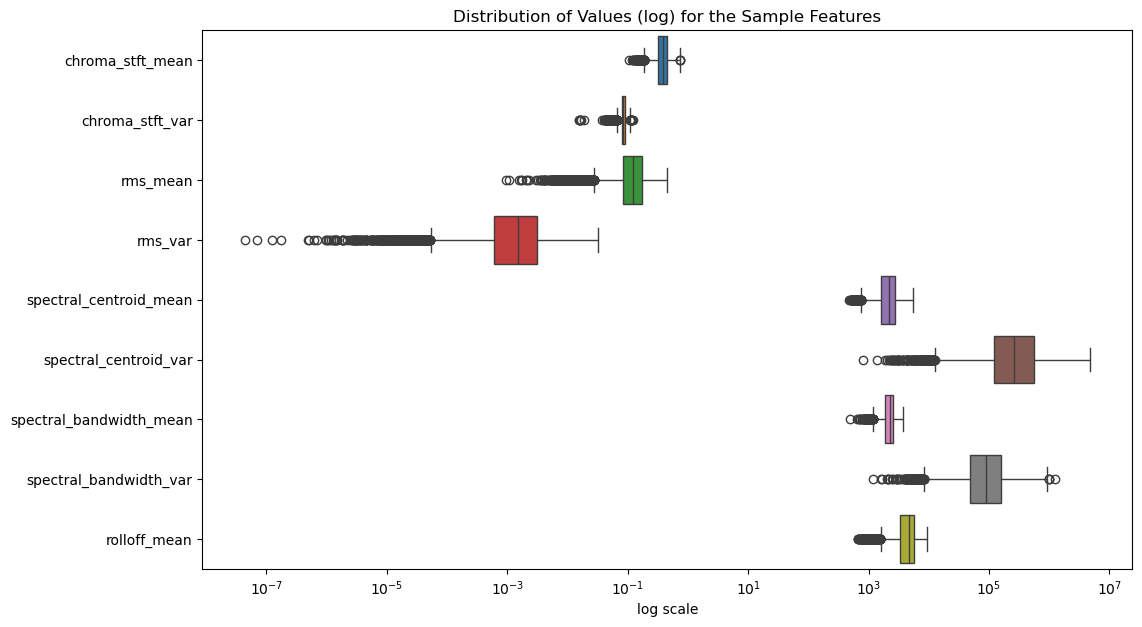

In [15]:
# boxplot for the first 9 features
# to explore outliers in the selected features
boxplot_9_features = data_3s.iloc[:,2:11]

# # Plot the feature importances
plt.figure(figsize=(12, 7))
plt.title('Distribution of Values (log) for the Sample Features')
plt.xlabel('log scale')
sns.boxplot(data=boxplot_9_features, log_scale=True, orient='h')

plt.show()

In [16]:
# write-up: I cannot see any pair of features have a clear boundary, 
# logistic regression is likely to perform pretty poorly in this ML problem.

### Feature selection

#### Linear Correlation

I explore standard correlation coefficients for each numeric variable in the dataset with the heatmap. Very quickly it beacomes clear to me that this method will not be very useful in the context of so many variables. Another important caveat is that using this approach I will not find non-linear relationships in the data that might be cruicial.  

<Axes: >

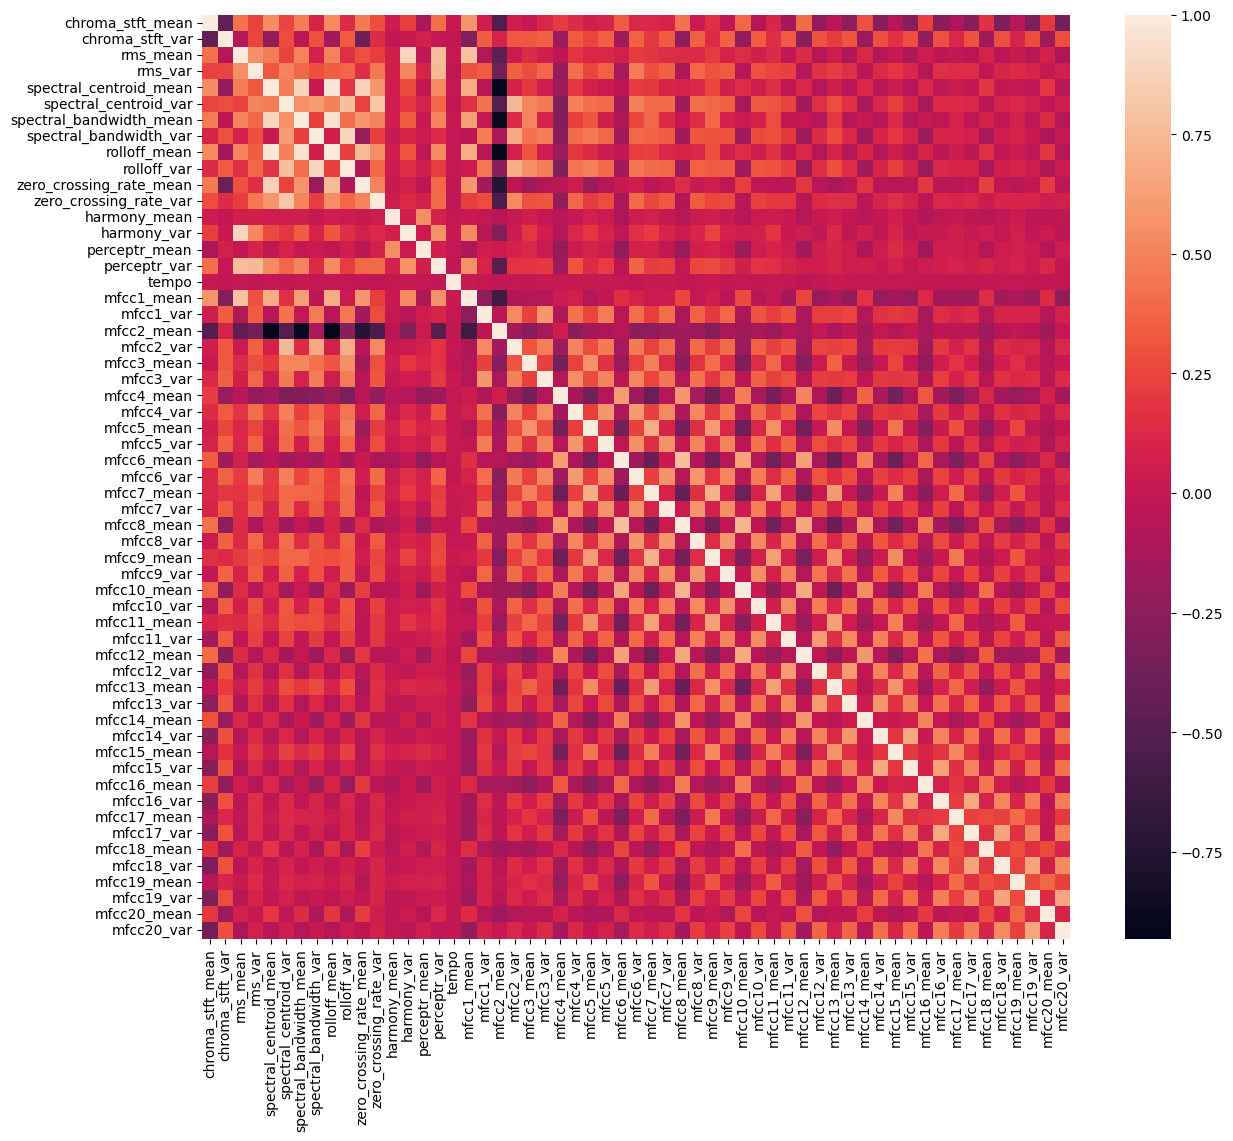

In [17]:
corr_matrix = data_3s_v1.corr(numeric_only=True) # produce correlation matrix for numeric attributes only

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix)

The strongest correlations appera to be present in the upper left corner of the heatmap. I zoom in to better see the first 20 attributes:

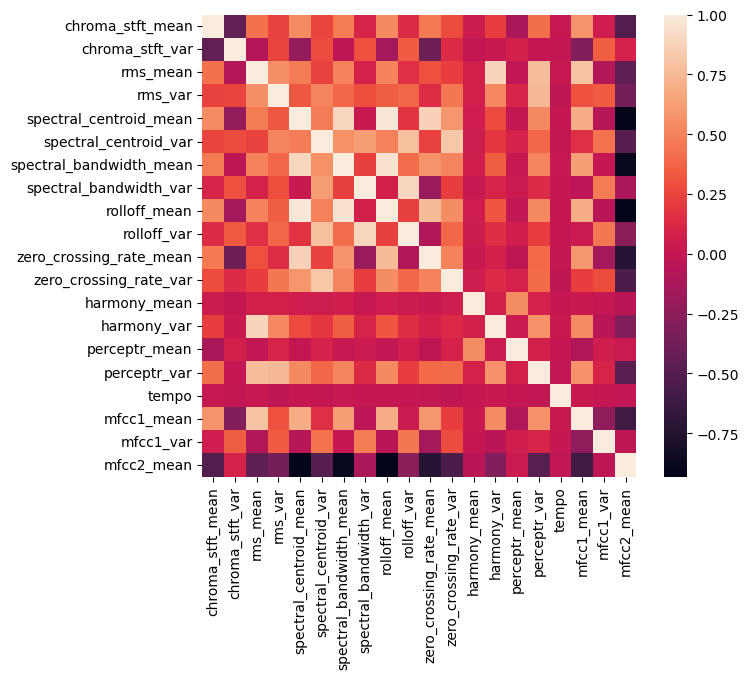

In [18]:
corr_selection = corr_matrix.iloc[:20,:20]

plt.figure(figsize=(7, 6))
sns.heatmap(corr_selection)
plt.show()

The more 'focused' heatmap helps to zone in on the promising features for linear relationships.

In [19]:
# prepare temporary train/test sets for feature imporatance search

input_features_temp, target_temp = data_3s_v1.iloc[:,:-1], data_3s_v1.iloc[:,-1:]

# Temporarily split the data into training and testing sets for the feature importance search
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(input_features_temp, target_temp, 
                                                                        test_size=0.2, random_state=seed, 
                                                                        stratify=data_3s_v1['label'])
# Convert target to 1D array
y_train_temp = y_train_temp.squeeze()
y_test_temp = y_test_temp.squeeze()

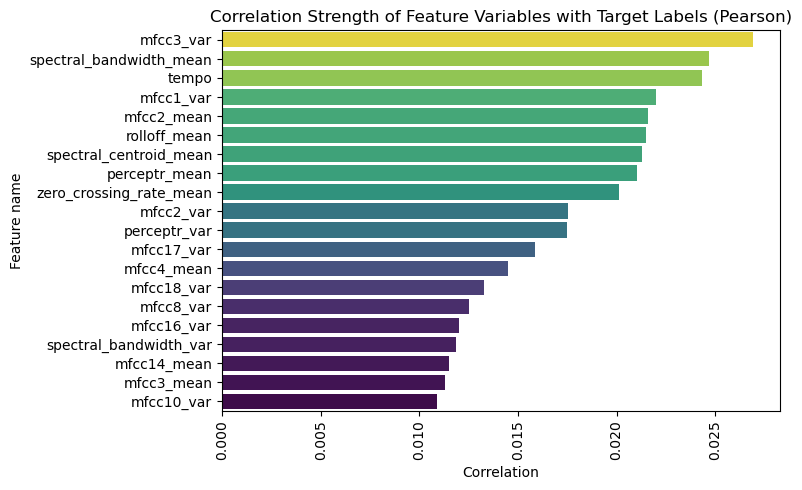

In [20]:
# Explore Pearson's corelation coefficients with the target variable

# encode labels in y
l_encoder = LabelEncoder()
y_encoded_temp = pd.Series(l_encoder.fit_transform(y_train_temp), name='target_label')

correlation_with_target = X_train_temp.apply(lambda col: col.corr(y_encoded_temp)).abs()
correlation_pearson = correlation_with_target.sort_values(ascending=False)[:20]

# # Plot the 10 strongest correlations (Pearson's)
plt.figure(figsize=(8, 5))
plt.title('Correlation Strength of Feature Variables with Target Labels (Pearson)')
plt.xlabel('Correlation')
plt.ylabel('Feature name')
sns.barplot(x=correlation_pearson, y=correlation_pearson.index, 
            hue=correlation_pearson, palette='viridis', legend=None)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### Correlation-Based Feature Selection (CBFS)

In [21]:
# use Correlation-Based Feature Selection (CBFS) to dentify features with strong positive or negative correlation to the target
# and eliminate features that are highly correlated with each other to minimize multi-collinearity among selected features

def cbfs(X, y, corr_y_threshold=0.005, corr_other_threshold=0.05):

    # Calculate correlation of all feature variables with target variable
    correlation_with_target = X.apply(lambda col: col.corr(y)).abs()
    
    # Calculate correlations between all feature variables
    feature_correlation_matrix = X.corr().abs()
    
    # Select features based on correlation criteria
    selected_features = []
    for feature in X.columns:
        # Check correlation with target if it's larger than the threshold
        if correlation_with_target[feature] >= corr_y_threshold:
            # Check for low inter-feature correlation
            low_inter_corr = all([abs(feature_correlation_matrix.loc[feature, other]) < corr_other_threshold for other in selected_features])
            if low_inter_corr or len(selected_features) == 0:
                selected_features.append(feature)
    
    return X[selected_features].columns

cbfs_selected_features = cbfs(X_train_temp, y_encoded_temp, corr_y_threshold=0.005, corr_other_threshold=0.5)

# Correlation-Based Feature Selection with chosen thresholds
pd.Series(cbfs_selected_features)

0            chroma_stft_mean
1             chroma_stft_var
2                     rms_var
3     spectral_bandwidth_mean
4      spectral_bandwidth_var
5                harmony_mean
6                       tempo
7                   mfcc1_var
8                  mfcc4_mean
9                   mfcc4_var
10                 mfcc5_mean
11                  mfcc9_var
12                mfcc10_mean
13                 mfcc13_var
14                mfcc16_mean
15                 mfcc16_var
16                mfcc17_mean
17                mfcc18_mean
18                 mfcc19_var
19                mfcc20_mean
dtype: object

#### Mutual Information

In [22]:
# Exploring mutual information to capture complex non-linear relationships between the feature variables and target variable
# similarly to estimating k-nearest neighbors distances

mutual_info = mutual_info_classif(X_train_temp, y_encoded_temp)

# sort in descending order 
sorted_indices = np.argsort(mutual_info)[::-1]
mutual_info_sorted = mutual_info[sorted_indices]
feature_names_sorted = X_train_temp.columns[sorted_indices]

# store 10 features with the highest estimates in a variable
mutual_10_features = feature_names_sorted[:10]

# display features with th highest 20 mutual information estimates as a series
pd.Series(mutual_info_sorted, index=feature_names_sorted)[:20]

perceptr_var               0.512828
spectral_bandwidth_mean    0.425957
rolloff_mean               0.393759
rms_var                    0.389302
chroma_stft_mean           0.376499
spectral_centroid_var      0.364346
mfcc1_mean                 0.360074
spectral_centroid_mean     0.355104
rms_mean                   0.337216
rolloff_var                0.307851
mfcc2_mean                 0.305883
zero_crossing_rate_var     0.269443
harmony_var                0.259325
mfcc4_mean                 0.256433
mfcc4_var                  0.255478
mfcc6_mean                 0.237225
mfcc5_var                  0.236411
mfcc6_var                  0.235510
mfcc8_mean                 0.231127
zero_crossing_rate_mean    0.226165
dtype: float64

#### Built-in Random Forest Feature Importance

In [23]:
# feature selection with Random Forest

# Train the RandomForestClassifier to find feature importance
model_feat_imp = RandomForestClassifier(n_estimators=50, random_state=seed)
model_feat_imp.fit(X_train_temp, y_train_temp)

# Extract feature importances
feature_importances = model_feat_imp.feature_importances_

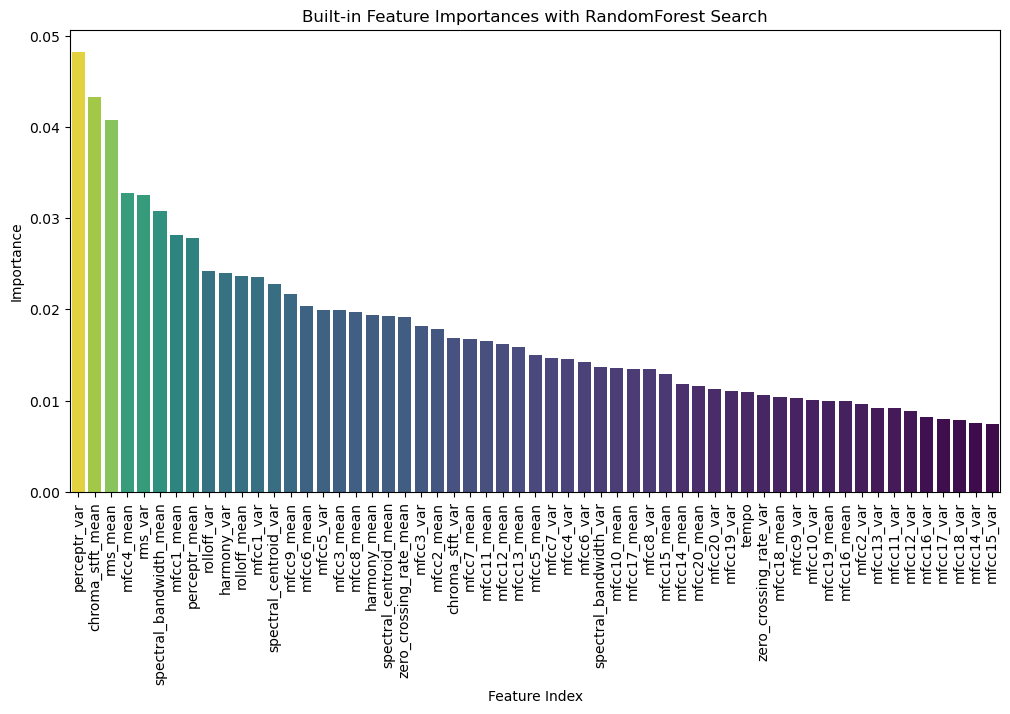

In [24]:
# Plot feature importances from high to low

sorted_indices = np.argsort(feature_importances)[::-1]  # Sort indices

# # Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Built-in Feature Importances with RandomForest Search')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

sns.barplot(x=X_train_temp.columns[sorted_indices], y=feature_importances[sorted_indices], errorbar=None,
           hue=feature_importances[sorted_indices],palette='viridis', legend=None)
plt.xticks(rotation=90)
plt.show()

In [25]:
# 10 features with the highest importance according to RandomForest search

rand_for_10_features = X_train_temp.columns[sorted_indices][:10]
pd.Series(feature_importances[sorted_indices][:10],index=rand_for_10_features)

perceptr_var               0.048212
chroma_stft_mean           0.043250
rms_mean                   0.040740
mfcc4_mean                 0.032749
rms_var                    0.032571
spectral_bandwidth_mean    0.030811
mfcc1_mean                 0.028179
perceptr_mean              0.027834
rolloff_var                0.024174
harmony_var                0.024018
dtype: float64

#### Built-in Gradient Boosting Classifier Feature Importance

In [26]:
# # Commented out because of long computing time
# # Use Gradient Boosting Classifier to explore feature importance


# gb_classifier = GradientBoostingClassifier(n_estimators=50,
#                                            learning_rate=0.1,
#                                            max_depth=3,
#                                            random_state=seed 
# )

# # Fit the model
# gb_classifier.fit(X_train_temp, y_encoded_temp)

# # Extract feature importances
# feature_importances_gb = gb_classifier.feature_importances_

In [27]:
feature_importances_gb = np.array([
       0.0421065, 0.04033421, 0.01362731, 0.04876308, 0.00888433,
       0.01230539, 0.07286134, 0.00607808, 0.01371636, 0.03355423,
       0.02062065, 0.00156126, 0.02460124, 0.02730365, 0.04591387,
       0.17132201, 0.01867237, 0.01969555, 0.03197536, 0.00818419,
       0.00139946, 0.01550472, 0.01206165, 0.06084182, 0.00916543,
       0.01268043, 0.0176924 , 0.01905511, 0.00603167, 0.01193651,
       0.01250277, 0.01263111, 0.00605804, 0.02972906, 0.00417507,
       0.00582354, 0.00650431, 0.01619667, 0.00159928, 0.01545807,
       0.00419572, 0.00792642, 0.00114267, 0.00717466, 0.00049281,
       0.00139969, 0.00138801, 0.00425746, 0.00136042, 0.00949407,
       0.00142388, 0.00159067, 0.00167921, 0.00170404, 0.00611592,
       0.00530079, 0.00422549
])

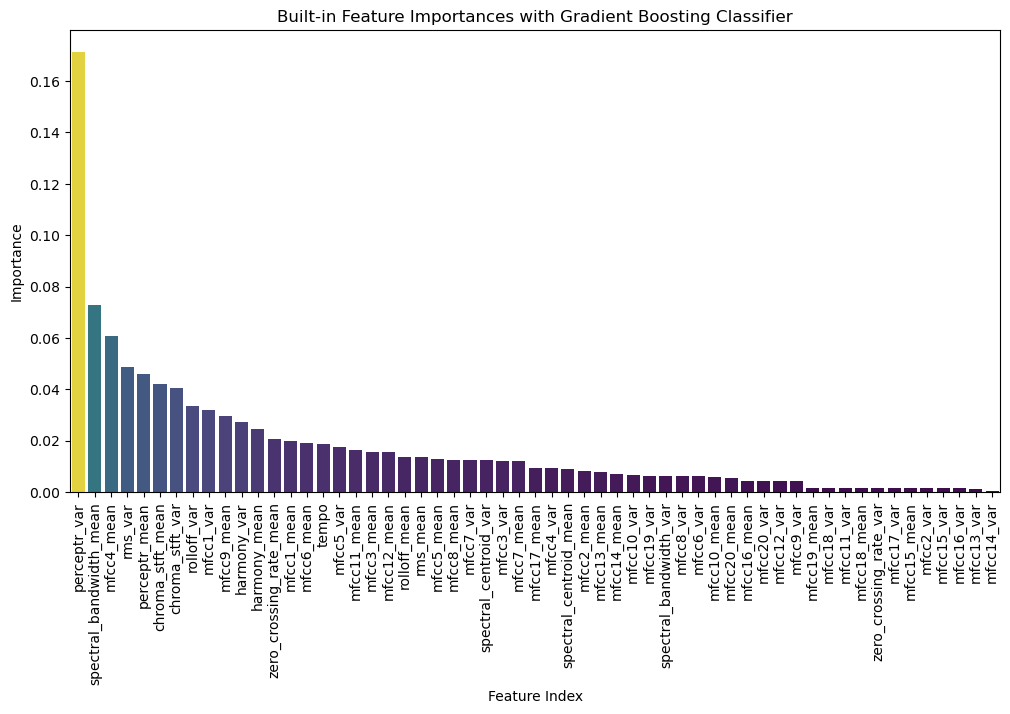

In [28]:
# Plot built-in feature importances from Gradient Boosting Classifier

sorted_indices = np.argsort(feature_importances_gb)[::-1]  # Sort indices

# store 10 features with the highest importance according to GBClassifier
gb_10_features = X_train_temp.columns[sorted_indices][:10]

# # Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Built-in Feature Importances with Gradient Boosting Classifier')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

sns.barplot(x=X_train_temp.columns[sorted_indices], y=feature_importances_gb[sorted_indices], errorbar=None,
           hue=feature_importances_gb[sorted_indices], palette='viridis', legend=None)
plt.xticks(rotation=90)
plt.show()

#### Permutation Feature Importance

In [29]:
# # Commented out because of long computing time
# # Explore feature significance with Permutation Feature Importance


# # train default RandomForest model for the permutation imporatance 
# perm_model = RandomForestClassifier(random_state=seed)
# perm_model.fit(X_train_temp, y_train_temp)

# perm_importance = permutation_importance(perm_model, 
#                                          X_train_temp,
#                                          y_train_temp,
#                                          n_repeats=10,
#                                          scoring='accuracy',
#                                          random_state=seed
# )

In [30]:
# perm_importance_mean = perm_importance.importances_mean
# the output permutation mean stored in the variable for computational reasons

perm_importance_mean = np.array([
        3.92892893e-03,  1.50150150e-04,  7.50750751e-05,  2.22044605e-17,
        2.50250250e-05,  7.50750751e-05,  5.00500501e-05, -1.00100100e-04,
       -2.50250250e-05,  5.00500501e-05,  7.50750751e-05,  0.00000000e+00,
       -2.50250250e-05,  2.22044605e-17,  0.00000000e+00,  5.00500501e-04,
        0.00000000e+00,  1.25125125e-04,  1.00100100e-04, -5.00500501e-05,
        7.50750751e-05,  2.22044605e-17, -7.50750751e-05,  1.30130130e-03,
        2.22044605e-17, -2.50250250e-05, -2.50250250e-05,  7.50750751e-05,
        0.00000000e+00, -1.00100100e-04,  7.50750751e-05, -2.50250250e-05,
        0.00000000e+00,  3.50350350e-04,  5.00500501e-05,  2.22044605e-17,
        7.50750751e-05, -2.50250250e-05,  7.50750751e-05,  1.25125125e-04,
        0.00000000e+00, -7.50750751e-05,  2.50250250e-05,  7.50750751e-05,
        5.00500501e-05,  2.50250250e-05,  5.00500501e-05,  5.00500501e-05,
        5.00500501e-05,  2.50250250e-05,  0.00000000e+00,  0.00000000e+00,
        2.50250250e-05,  5.00500501e-05,  4.44089210e-17, -1.00100100e-04,
        5.00500501e-05
])

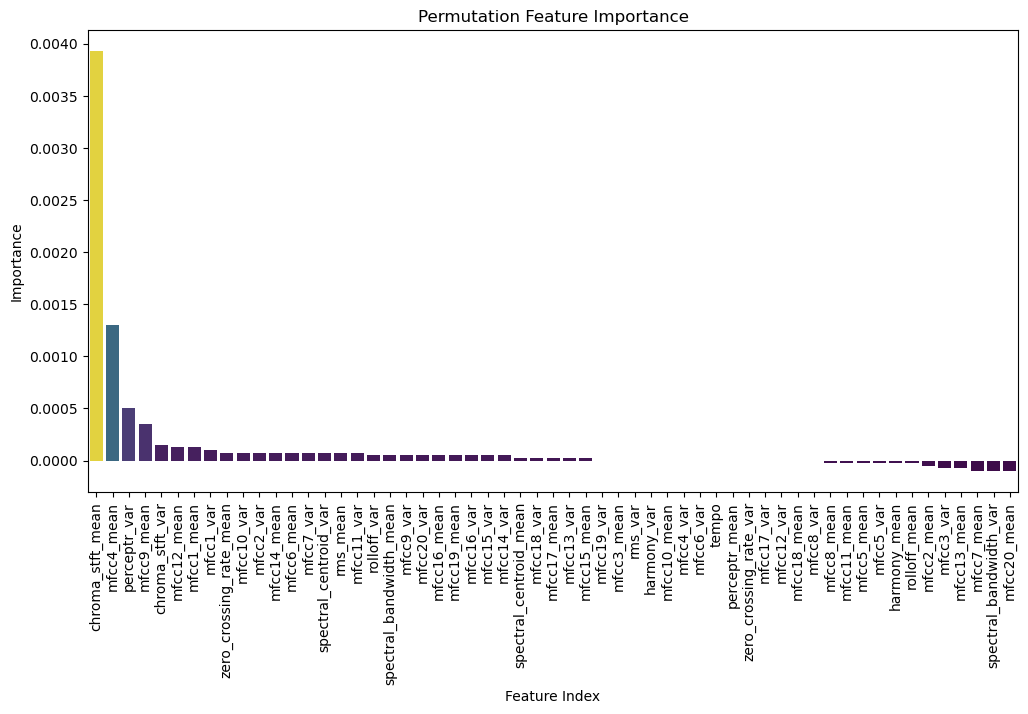

In [31]:
sorted_indices = np.argsort(perm_importance_mean)[::-1]

perm_importance_mean_sorted = perm_importance_mean[sorted_indices]
perm_importance_features = X_train_temp.columns[sorted_indices]


# # Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Permutation Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance')

sns.barplot(x=perm_importance_features, y=perm_importance_mean_sorted, 
            hue=perm_importance_mean_sorted, palette='viridis', errorbar=None, legend=None)
plt.xticks(rotation=90)
plt.show()

In [32]:
# store the 10 features with the highest score in the variable
permutation_10_features = perm_importance_features[:10]

# display the 10 features together with their highest accuracy scores as series
pd.Series(perm_importance_mean_sorted[:10], index=permutation_10_features)

chroma_stft_mean           0.003929
mfcc4_mean                 0.001301
perceptr_var               0.000501
mfcc9_mean                 0.000350
chroma_stft_var            0.000150
mfcc12_mean                0.000125
mfcc1_mean                 0.000125
mfcc1_var                  0.000100
zero_crossing_rate_mean    0.000075
mfcc10_var                 0.000075
dtype: float64

In [33]:
# compute count for the most frequent features in the search
best_features_names = [
    cbfs_selected_features,
    mutual_10_features,
    rand_for_10_features,
    gb_10_features,
    permutation_10_features
]

best_features_collected = pd.Series()
f_number = 0

for features in best_features_names:
    f_number += len(features)
    best_features_collected = pd.concat([best_features_collected, pd.Series(features)],ignore_index=True)

best_features_counts = best_features_collected.value_counts().sort_values(ascending=False)

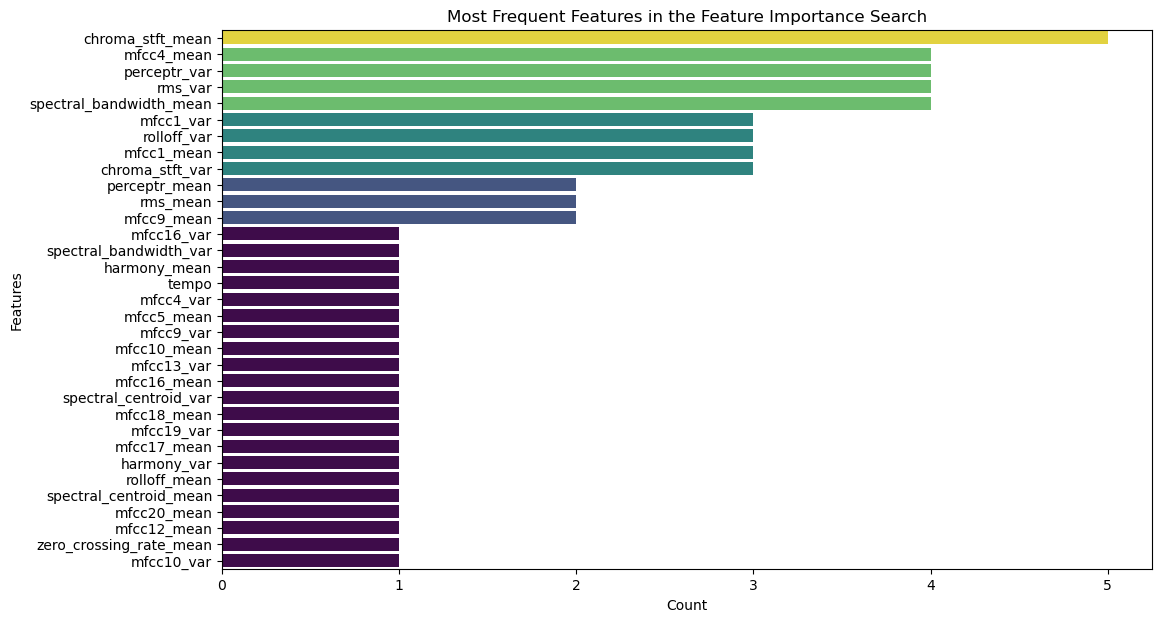

In [34]:
# plot best features with their counts

plt.figure(figsize=(12, 7))
plt.title('Most Frequent Features in the Feature Importance Search')
plt.xlabel('Count')
plt.ylabel('Features')

# Create horizontal bar plot
sns.barplot(
    x=best_features_counts.values, 
    y=best_features_counts.index, 
    palette='viridis',
    hue=best_features_counts.values,
    legend=None
)
plt.show()

In [35]:
# storing the most frequent features in variables
# selected_features_4 = list(best_features_counts.index[:4])
selected_features = list(best_features_counts.index[:8]) # 8 features
selected_features_less = selected_features[:4]

In [36]:
selected_features

['chroma_stft_mean',
 'mfcc4_mean',
 'perceptr_var',
 'rms_var',
 'spectral_bandwidth_mean',
 'mfcc1_var',
 'rolloff_var',
 'mfcc1_mean']

#### Context and Domain Knowledge

In [37]:
# Literature review about selected features. Compare domain knowledge with the ones that have been found in the searches above


Features: 1 to 4



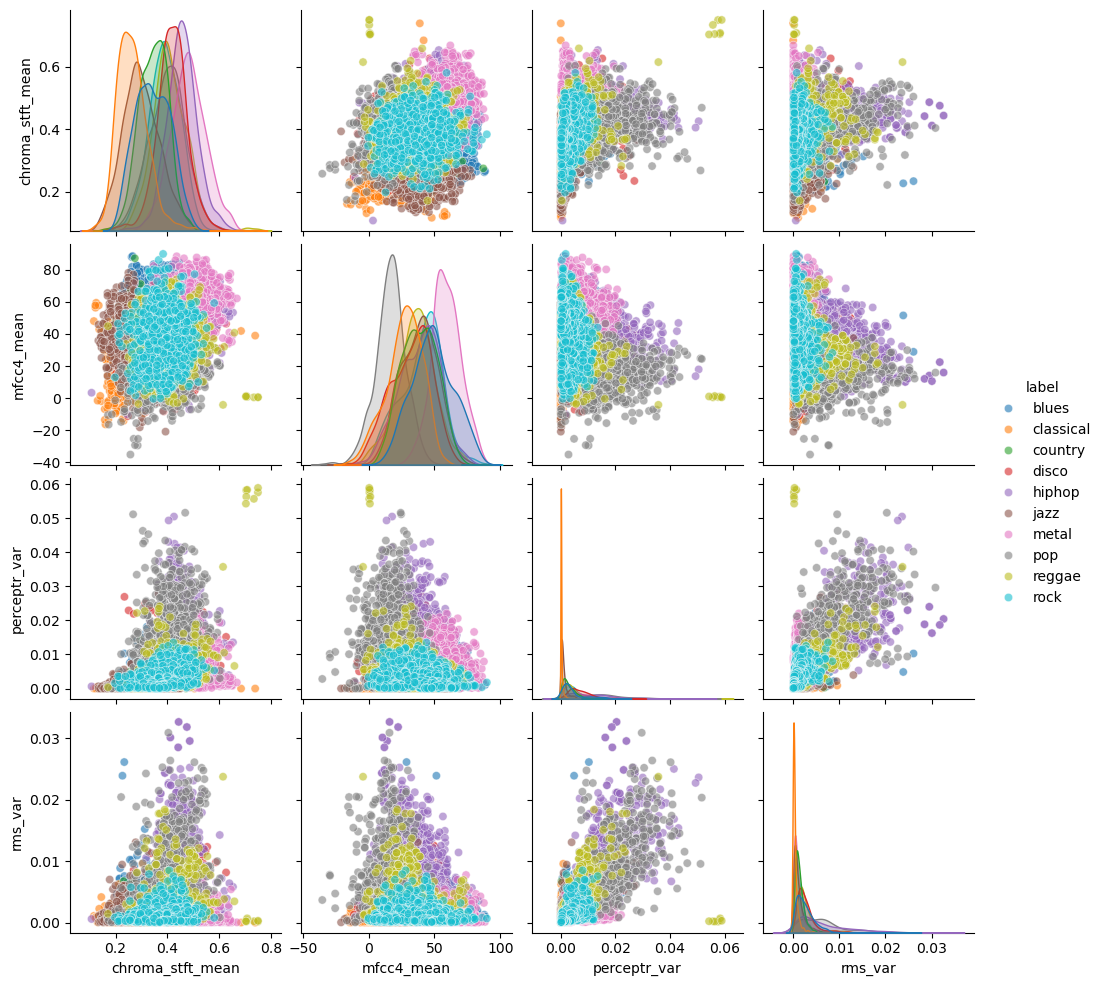


Features: 5 to 8



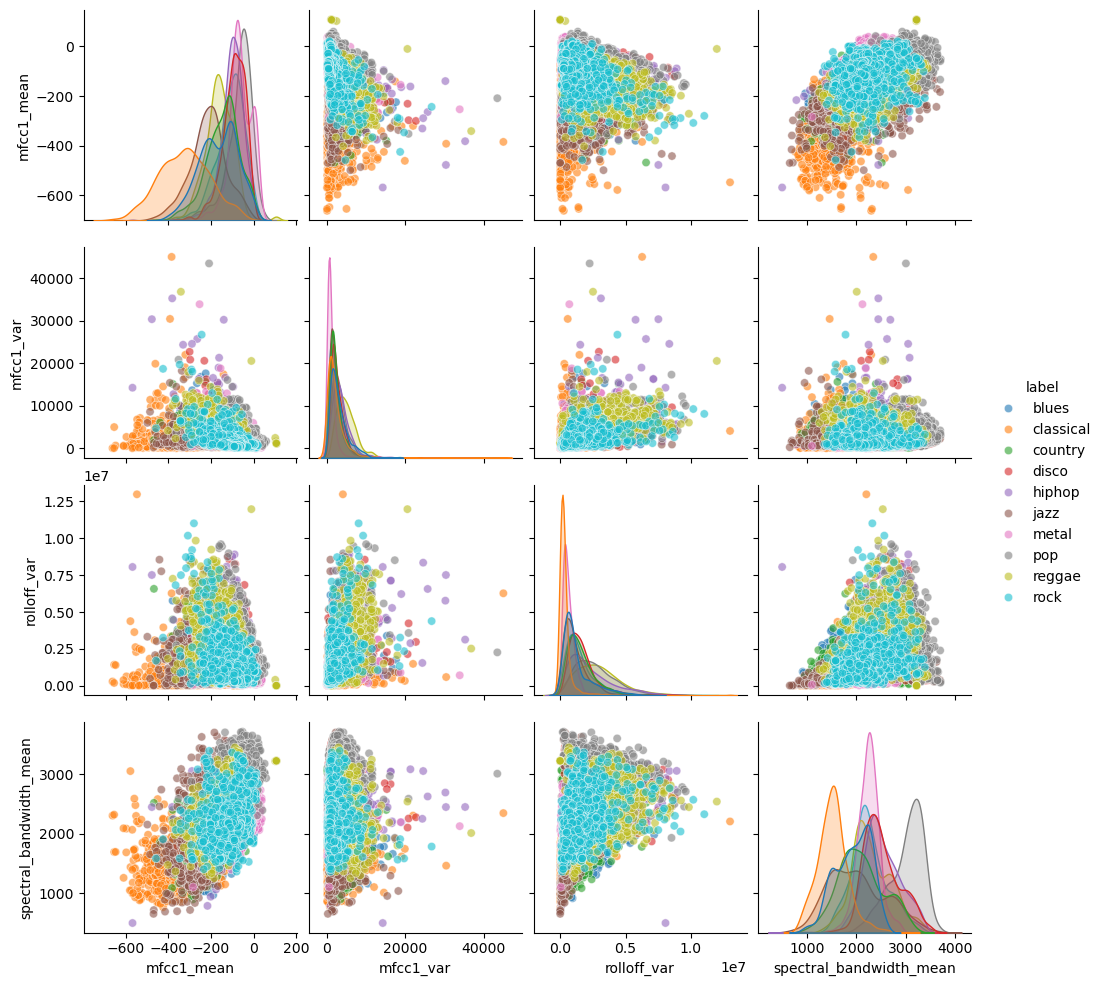

In [38]:
# plot all selected features with pairplots:

plot_features = data_3s[selected_features + [data_3s.columns[-1]]]
group_size = 4

for i in range(0, len(plot_features.columns) - 1, group_size):
    feature_group = plot_features.columns[i : i + group_size].union(['label'])

    print(f"\nFeatures: {i+1} to {i +group_size}\n")
    # Create pairplot
    sns.pairplot(plot_features[feature_group], 
                 hue='label', 
                 diag_kind='kde',
                 plot_kws={'alpha': 0.6}
                )
    plt.show()

## Data preprocessing

### Data Splitting

In [39]:
# to prevent data leakage with data transformations, I split dataset into train/test subsets 
# all selected features included
# stratify samples based on labels

X_train, X_test, y_train, y_test = train_test_split(
    data_3s[selected_features], 
    data_3s['label'], 
    test_size=0.2, 
    random_state=seed, 
    stratify=data_3s['label']
)

### Handling outliers

#### Removing outliers with ZScore method

In [40]:
# Modify X_train, y_train by removing all extreme outliers

# Custom function removing extreme outliers 
def remove_outliers_zscore(X_subset, y_subset, threshold=3):
    """Remove outliers beyond ±3 standard deviations (Z-score method)"""
    
    # Z-score calculated using mean and standard deviation
    z = np.abs((X_subset - X_subset.mean()) / X_subset.std())
    
    # Create boolean mask for non-outliers
    mask = (z < threshold).all(axis=1)
    
    return X_subset[mask], y_subset[mask]

# modify train subset data
X_train_zscore, y_train_zscore = remove_outliers_zscore(X_train, y_train)

# modify test subset data
X_test_zscore, y_test_zscore = remove_outliers_zscore(X_test, y_test)

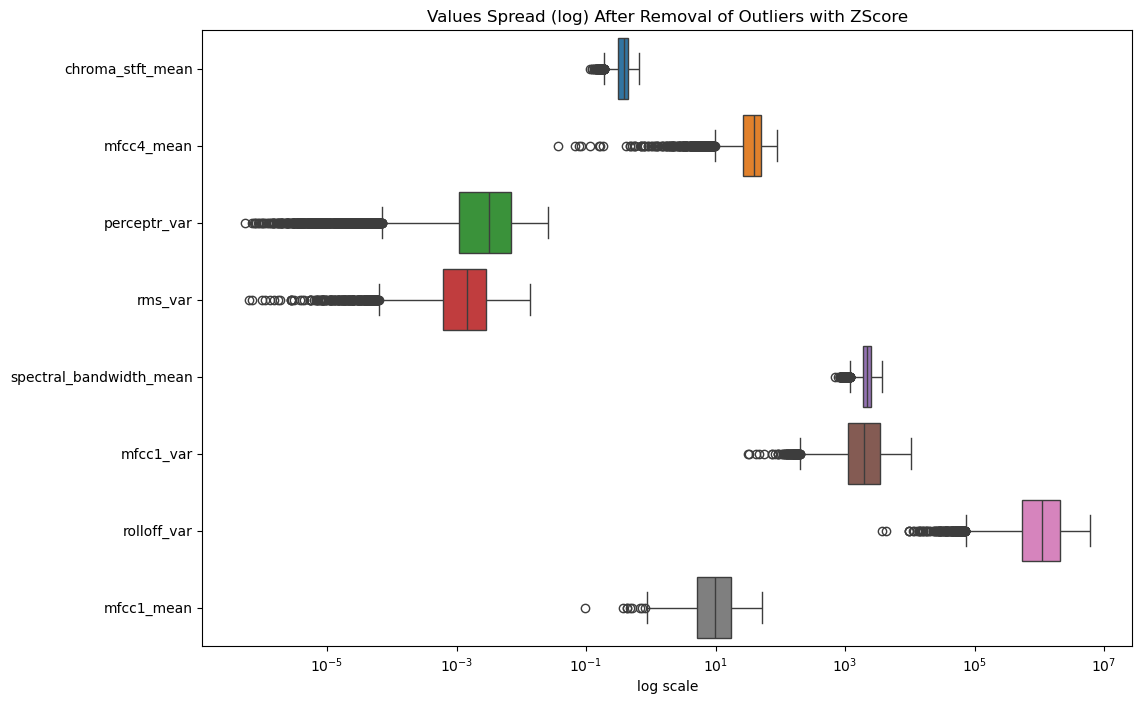

In [41]:
# # Plot the X_train after removing the extreme outliers
plt.figure(figsize=(12, 8))
plt.title('Values Spread (log) After Removal of Outliers with ZScore')
plt.xlabel('log scale')
sns.boxplot(data=X_train_zscore, log_scale=True, orient='h')

plt.show()

#### Removing outliers with IQR method

In [42]:
# Modify X_train, y_train by removing all outliers

# Custom function removing outliers 
def remove_outliers_iqr(X_subset, y_subset):
    """Remove outliers using Interquartile Range method"""
    
    # Create mask for non-outliers across specified columns
    mask = np.ones(len(X_subset), dtype=bool)
    
    for column in X_subset.columns:
        # obtain q1 and q3
        Q1 = X_subset[column].quantile(0.25)
        Q3 = X_subset[column].quantile(0.75)
        # calculate iqr
        IQR = Q3 - Q1
        # store values for lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        column_mask = (X_subset[column] >= lower_bound) & (X_subset[column] <= upper_bound)
        mask = mask & column_mask
    
    return X_subset[mask], y_subset[mask]

# modify train subset data
X_train_iqr, y_train_iqr = remove_outliers_iqr(X_train, y_train)

# modify test subset data
X_test_iqr, y_test_iqr = remove_outliers_iqr(X_test, y_test)

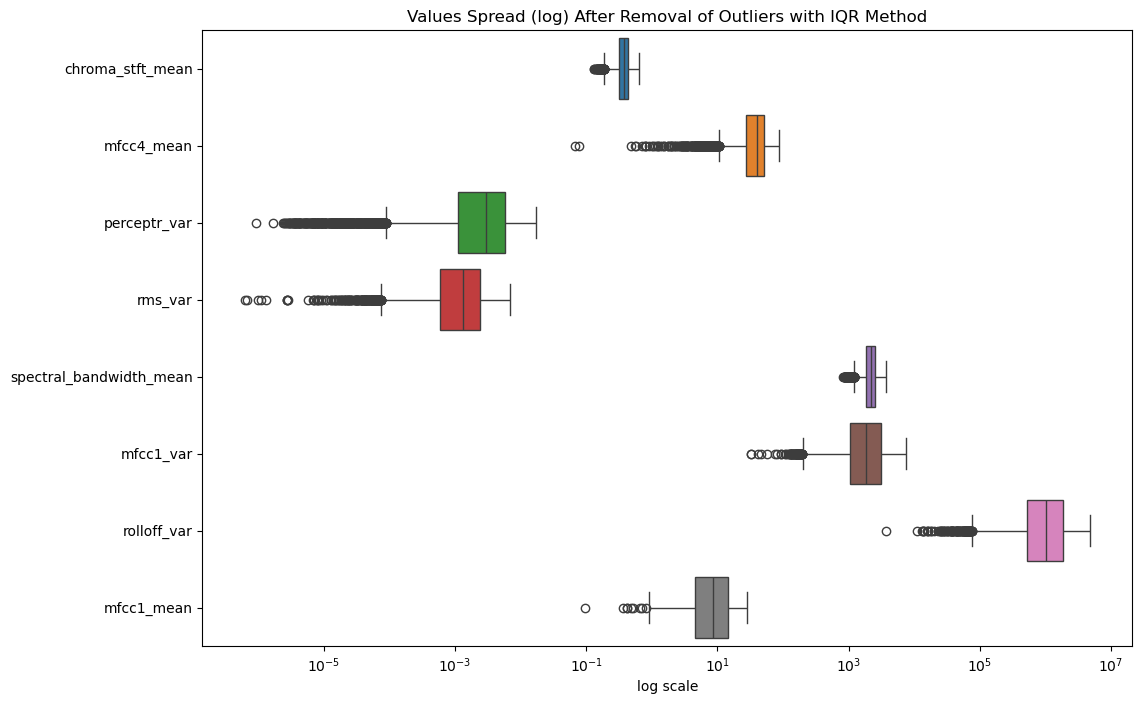

In [43]:
# # Plot the X_train after removing outliers
plt.figure(figsize=(12, 8))
plt.title('Values Spread (log) After Removal of Outliers with IQR Method')
plt.xlabel('log scale')
sns.boxplot(data=X_train_iqr, log_scale=True, orient='h')

plt.show()

### Features scaling and log

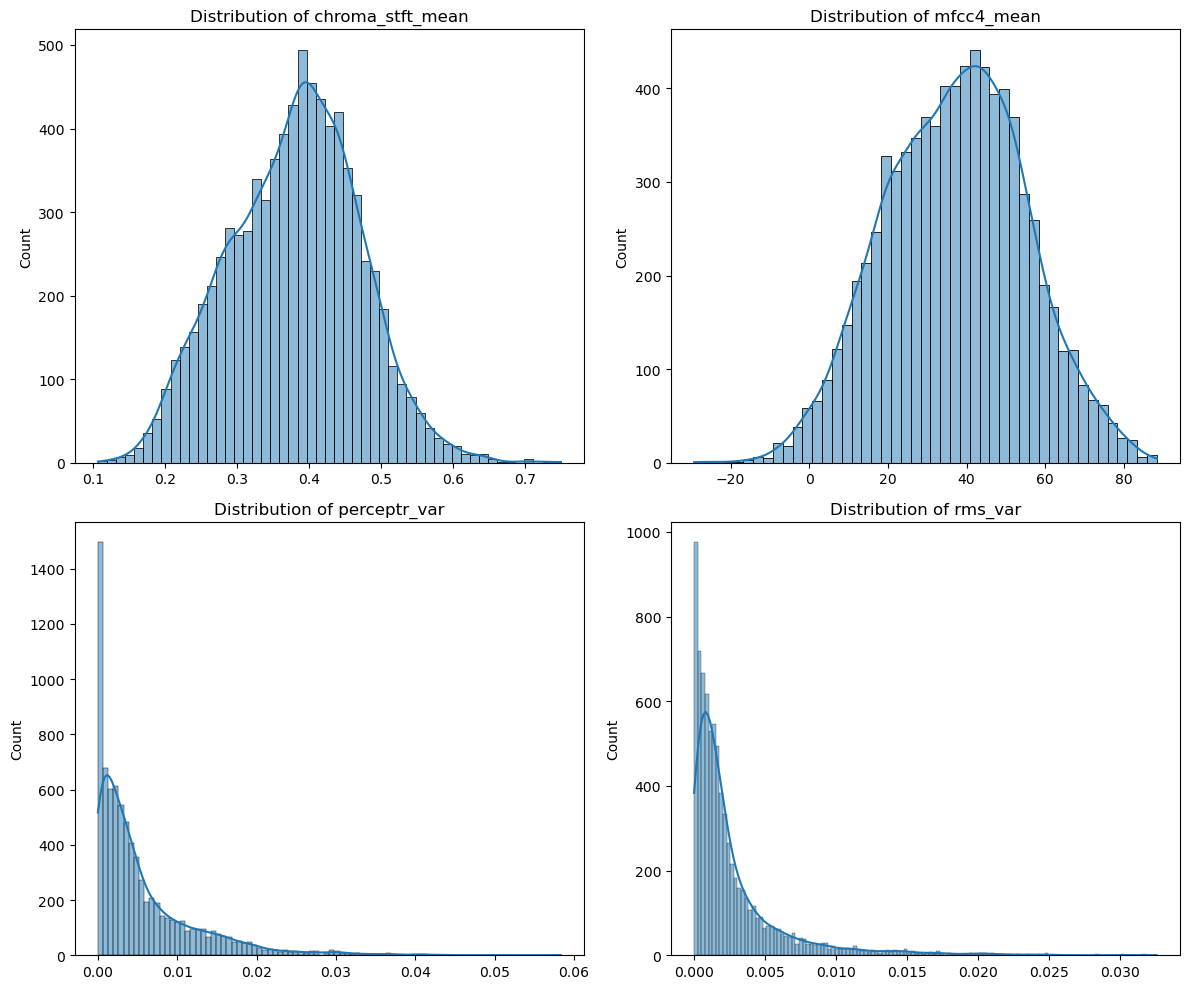

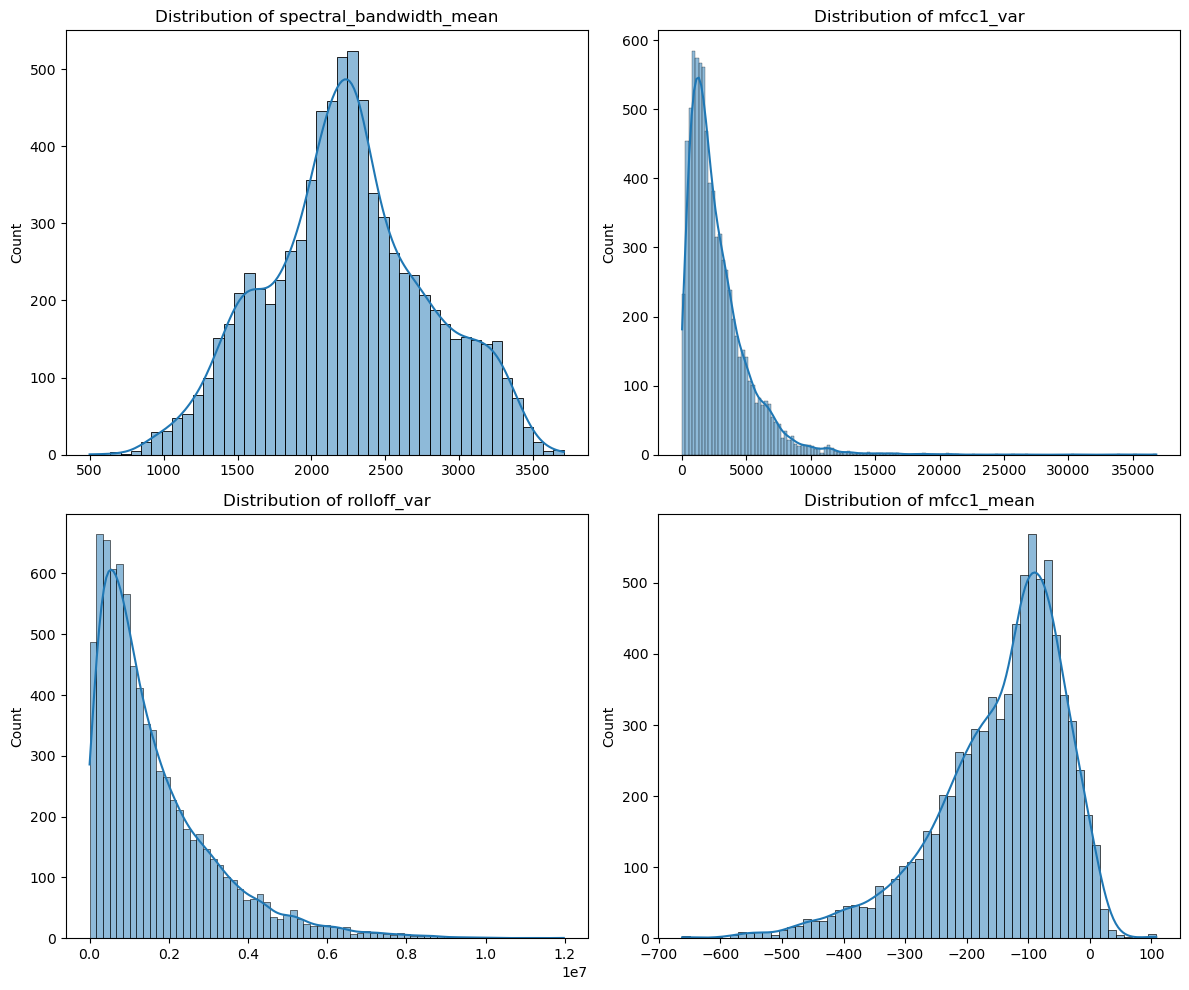

In [44]:
# plot histograms for all selected features - part 1

def plot_histogram_grid(df, features, color=None):
    """Plot histograms on a 2x2 grid of subplots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, ax=axes[i], kde=True, color=color)
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()

# plot firts part of the selected_features 
features_part1 = X_train[selected_features[:4]]
plot_histogram_grid(X_train, features_part1)

# plot second part of the selected_features 
features_part2 = X_train[selected_features[4:]]
plot_histogram_grid(X_train, features_part2)

In [45]:
# write-up: 

# Necessary scaling of all variables due to large spread of values 
# Normal distribution: 'chroma_stft_mean', 'mfcc4_mean', 'spectral_bandwidth_mean'
# Log required for skewed distributions: 'perceptr_var', 'rms_var', 'mfcc1_var', 'rolloff_var', 'mfcc1_mean'

In [46]:
# create pipeline for preprocessing of feature variables

# construct pipeline for numerical attributes that are approx. normal in distribution
scal_pipeline = make_pipeline(
    StandardScaler()
)
# coonstruct pipeline for numerical attributes that may benefit from logarithmic transformation
log_scal_pipeline = make_pipeline(
    FunctionTransformer((lambda x: np.log(x)), feature_names_out='one-to-one'),
    StandardScaler()
)

# construct separate pipeline to handle logarithmic transformation of 'spectral_bandwidth_mean'
log_scal_pipeline2 = make_pipeline(
    FunctionTransformer((lambda x: np.log(x+1)), feature_names_out='one-to-one'), # log(x+1) beacuse of NaN issue
    StandardScaler()
)

# construct a transformer containing both pipelines
preprocessing = ColumnTransformer([
    ('scal', scal_pipeline, ['chroma_stft_mean', 'mfcc4_mean', 'mfcc1_mean']),
    ('log', log_scal_pipeline, ['perceptr_var', 'rms_var', 'mfcc1_var', 'rolloff_var']),
    ('log2', log_scal_pipeline2, ['spectral_bandwidth_mean'])
])


Missing values after preprocessing:

chroma_stft_mean           0
mfcc4_mean                 0
perceptr_var               0
rms_var                    0
spectral_bandwidth_mean    0
mfcc1_var                  0
rolloff_var                0
mfcc1_mean                 0
dtype: int64



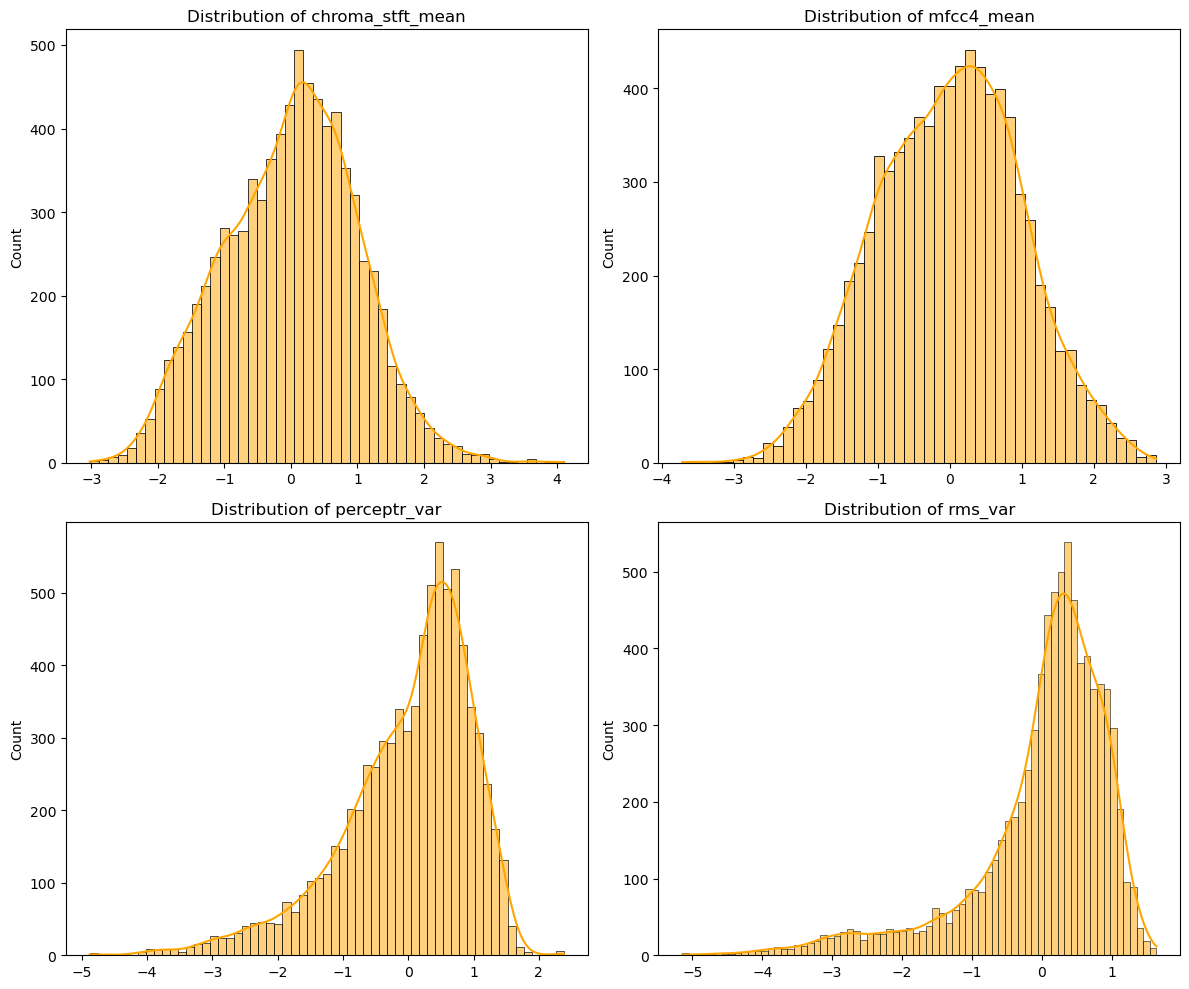

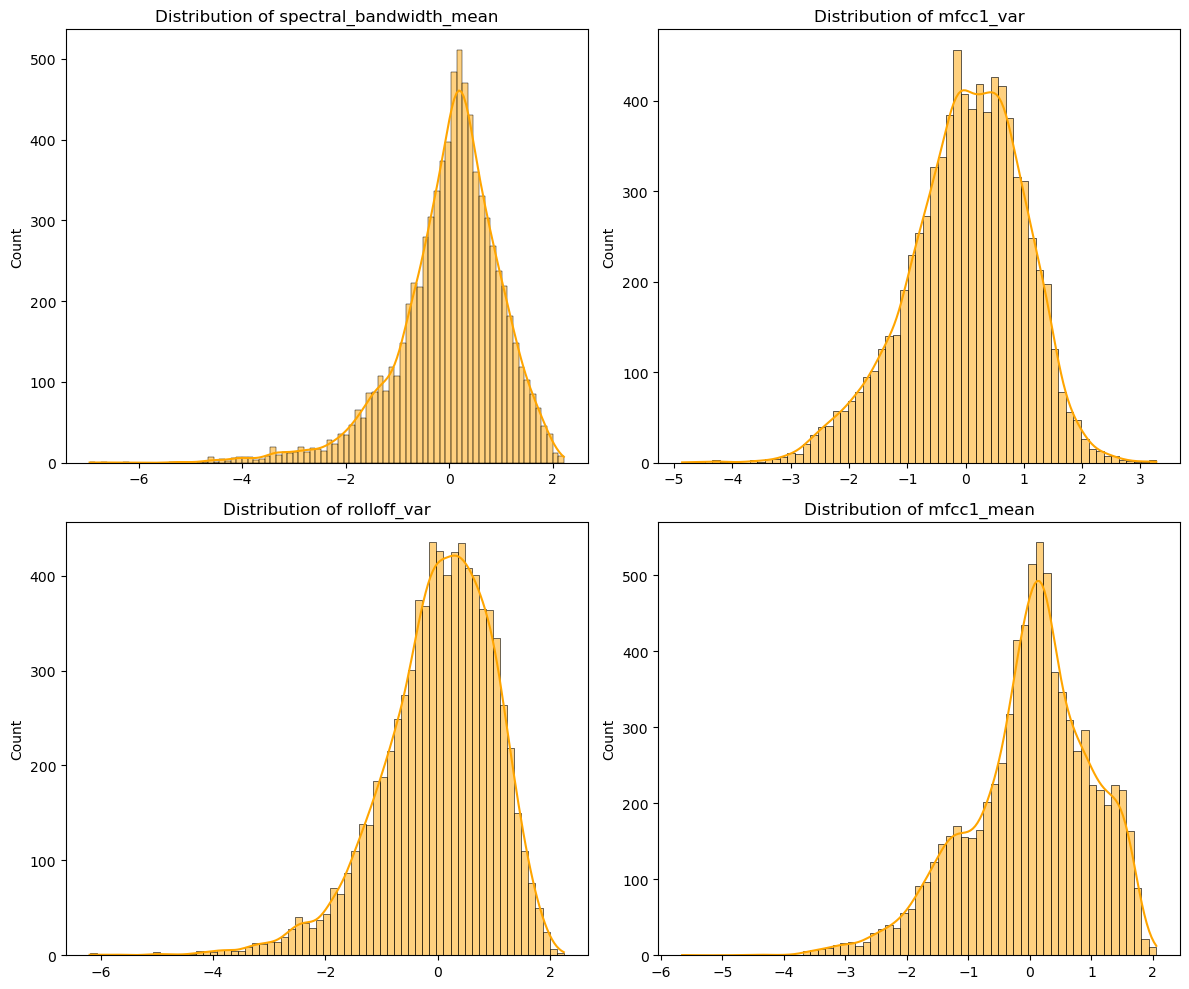

In [47]:
# Preprocessed features
prep_features = pd.DataFrame(preprocessing.fit_transform(X_train), 
                             columns=X_train.columns)

# Checking if the transformations have resulted in unintended missing values
print(f"\nMissing values after preprocessing:\n\n{prep_features.isnull().sum()}\n")

plot_histogram_grid(prep_features, prep_features.columns[:4], color='orange')
plot_histogram_grid(prep_features, prep_features.columns[4:], color='orange')

In [48]:
## write-up:

# Some key observations:

# Experienced issues with missing values after log transformations if scaling was performed first
# spectral_bandwith_mean required different treatment than other skewed features

# Normality: The transformed distributions (orange) generally have a more symmetric, bell-shaped appearance, indicating they are closer to a normal distribution. This is desirable as many machine learning algorithms perform better when the feature distributions are approximately normal.
# Reduced skewness: The original distributions (blue) exhibit significant positive skewness, with long tails towards the higher values. The log transformations have helped reduce this skewness, making the distributions more centered and symmetrical.
# Reduced range: The transformed distributions have a narrower range of values compared to the original data. This can help prevent issues with features having vastly different scales, which could lead to some features dominating the model training.
# Reduced outliers: The transformed distributions appear to have fewer extreme outliers compared to the original data. Outliers can negatively impact model performance, so reducing their presence is beneficial.

## Model training

### Logistic Regression

In [144]:
# Train a Logistic Regression model using the default settings

log_reg = make_pipeline(preprocessing, LogisticRegression(random_state=seed)) 
log_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scal',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['chroma_stft_mean',
                                                   'mfcc4_mean',
                                                   'mfcc1_mean']),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x00000236C0446FC0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['perceptr_var', 'rms_var',
                                                   'mfcc1_var',
                                                   'rolloff_var']),
                                                 ('log2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x00000236C0446F20>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['spectral_bandwidth_mean'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

In [159]:
# compile a list of rows from the training data that will be used to check accuracy of predictions
# in different models 

sampled_rows_idx = get_samples_indicises(y_train) # obtain indices 

# sample 10 rows from the X_train subset to compare predictions of classes consistently across different models
X_train_sampled = X_train.loc[X_train.index.isin(sampled_rows_idx)]

In [160]:
# Compare predicted classes against actual classes in the logistic regression model
y_10_predictions = log_reg.predict(X_train_sampled)
y_train_10_actual_classes = y_train.loc[y_train.index.isin(sampled_rows_idx)]

# print actual classes / predictions in the 10 sampled instances
for i, prediction in enumerate(y_10_predictions, start=0):    
    print(f"Actual: {y_train_actual.iloc[i]:<10} Predicted: {prediction}")


Actual: hiphop     Predicted: pop
Actual: metal      Predicted: metal
Actual: rock       Predicted: country
Actual: blues      Predicted: blues
Actual: jazz       Predicted: jazz
Actual: disco      Predicted: country
Actual: classical  Predicted: classical
Actual: reggae     Predicted: reggae
Actual: country    Predicted: disco
Actual: pop        Predicted: jazz


Classification Report:
               precision    recall  f1-score   support

       blues       0.44      0.48      0.46       800
   classical       0.88      0.89      0.88       799
     country       0.40      0.29      0.34       798
       disco       0.39      0.27      0.32       799
      hiphop       0.55      0.56      0.55       798
        jazz       0.53      0.55      0.54       800
       metal       0.70      0.81      0.76       800
         pop       0.58      0.73      0.64       800
      reggae       0.47      0.49      0.48       800
        rock       0.34      0.32      0.33       798

    accuracy                           0.54      7992
   macro avg       0.53      0.54      0.53      7992
weighted avg       0.53      0.54      0.53      7992



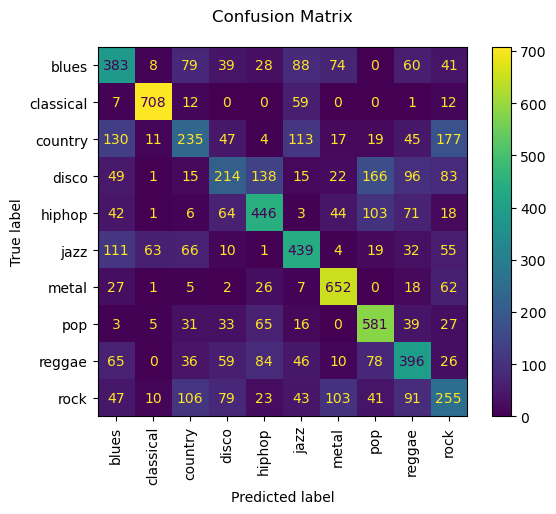

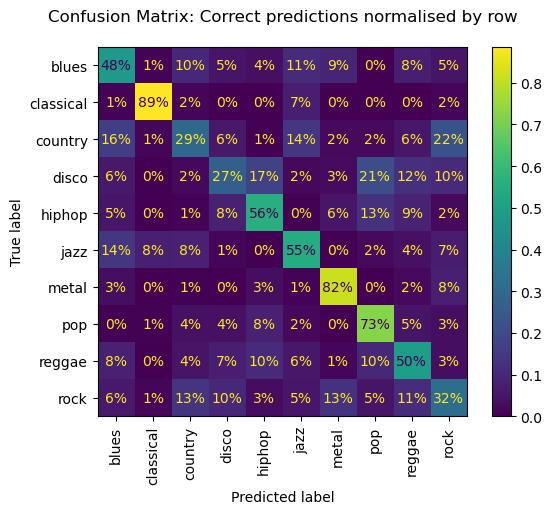

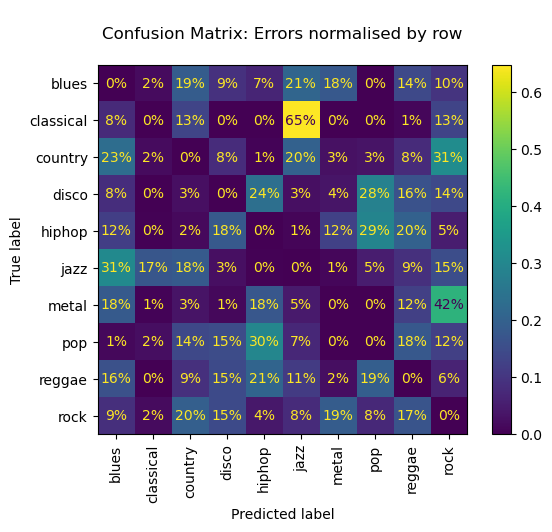

In [155]:
# cross-validate and return predictions for X_train over 5 folds
y_pred_logreg_CV = cross_val_predict(log_reg, X_train, y_train, cv=10)

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_train, y_pred_logreg_CV))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_logreg_CV,
                                       xticks_rotation='vertical')
plt.title("Confusion Matrix\n")
plt.show()

# Confusion Matrix with percentages of images classified correctly
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_logreg_CV,
                                       normalize="true",values_format=".0%",
                                       xticks_rotation='vertical')
plt.title("Confusion Matrix: Correct predictions normalised by row\n")
plt.show()

# Confusion Matrix with percentages of images classified incorrectly
sample_weight = (y_pred_logreg_CV != y_train) # put zero weight on correct predictions
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_logreg_CV,
                                        sample_weight=sample_weight,
                                        normalize="true",values_format=".0%",
                                        xticks_rotation='vertical')
plt.title("\nConfusion Matrix: Errors normalised by row\n")
plt.show()

#### Research Question 1

Does Logistic Regression achieve higher accuracy scores when trained on the music dataset with removed outliers? 


**Null Hypothesis (H0):** Removing outliers does not improve performance of the Logistic Regression model trained on the music dataset.

**Alternative Hypothesis (H1):** Removing outliers significantly improves performance of the Logistic Regression model trained on the music dataset.

**Methodology:**

* Baseline measurement: Obtain cross-validation predictions from two identical Logistic Regression Classifiers (with default hyperparameters) on two samples: the dataset before and after removal of outliers <br>
* Data processing method: Outliers are removed using IQR Method (1.5 Interquartile Range)<br>
* Comparison metric: Cross-validation accuracy scores for both trained models
* Statistical test: Wilcoxon signed-rank test


Missing values after preprocessing:

chroma_stft_mean           0
mfcc4_mean                 0
perceptr_var               0
rms_var                    0
spectral_bandwidth_mean    0
mfcc1_var                  0
rolloff_var                0
mfcc1_mean                 0
dtype: int64



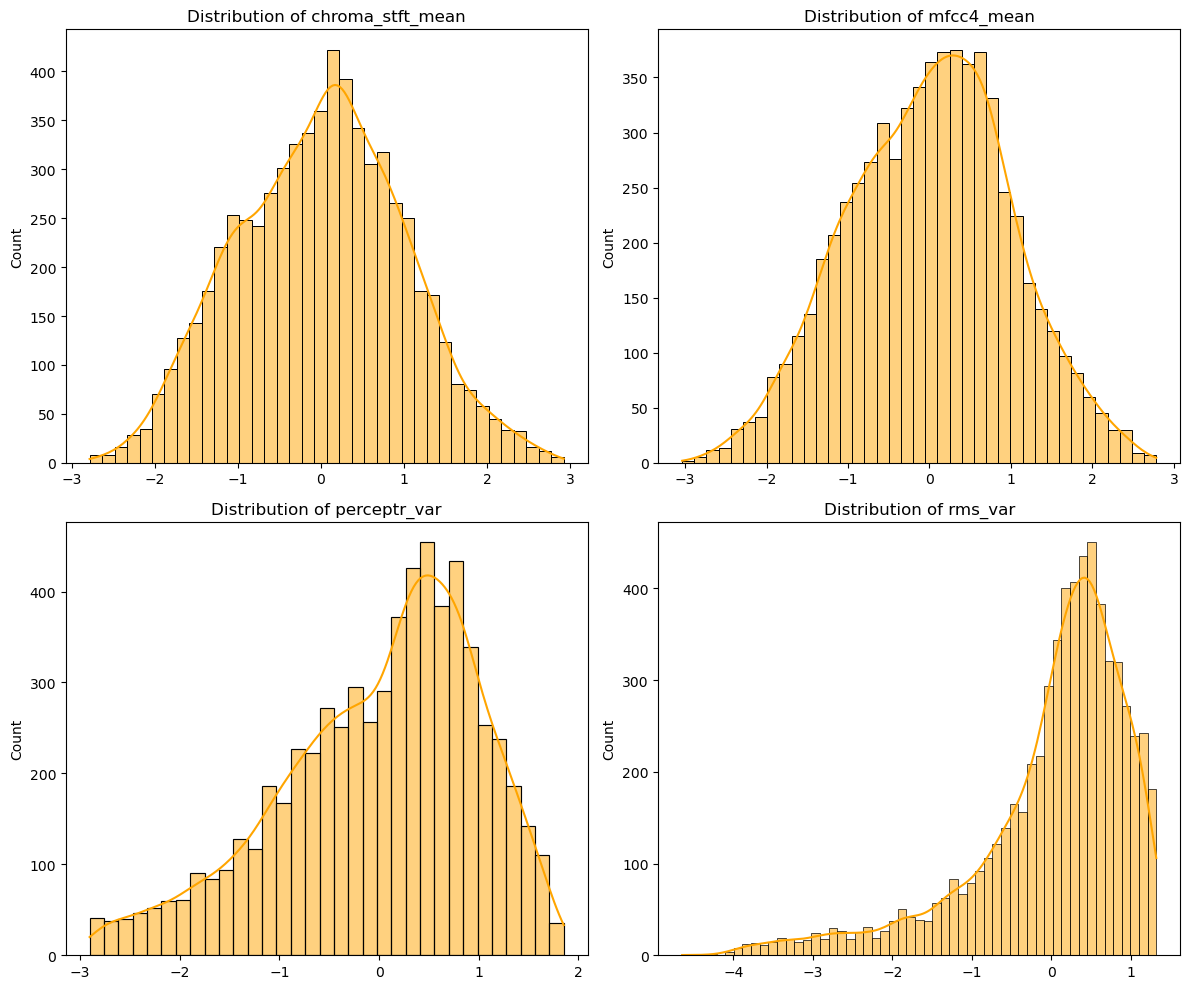

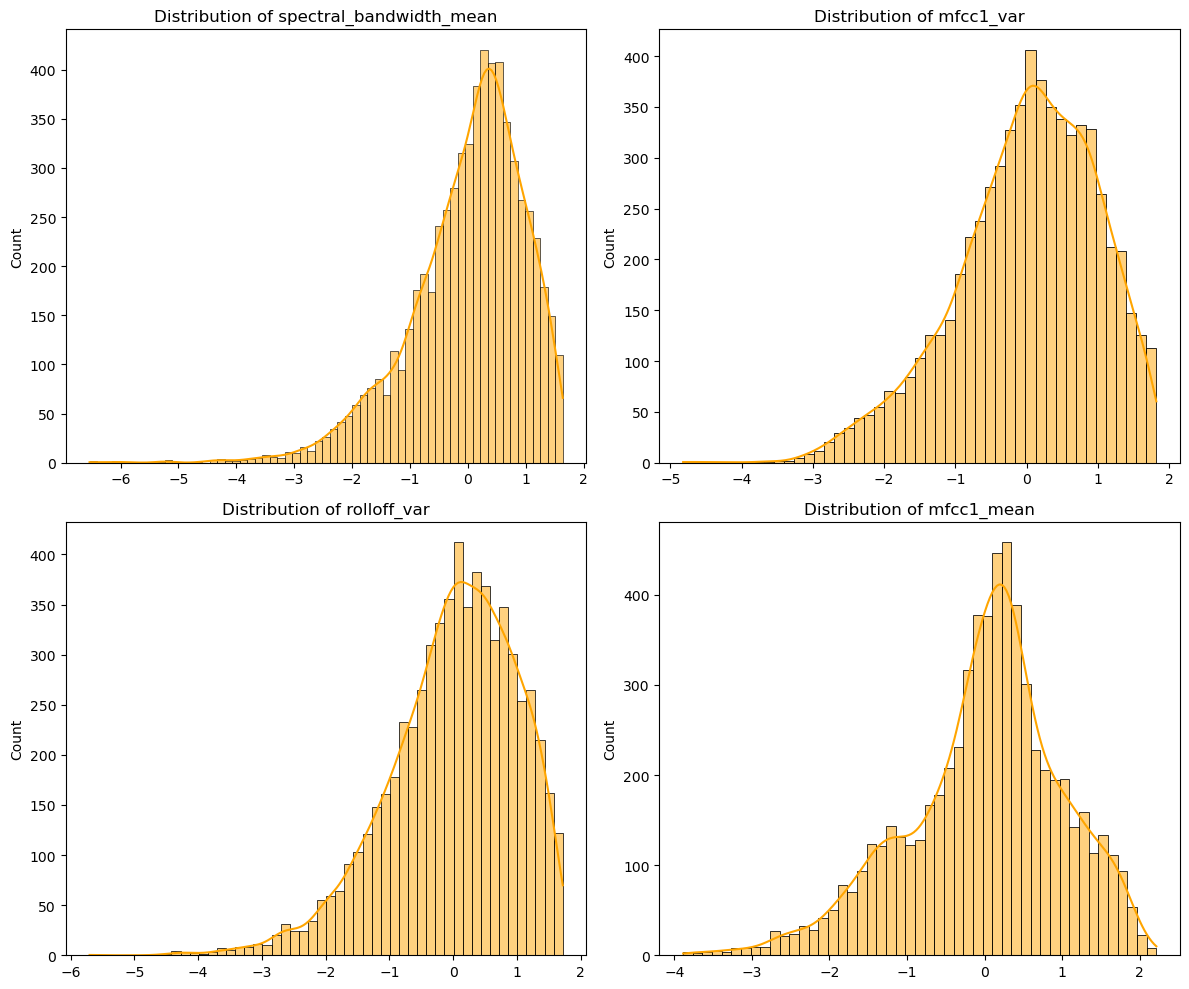

In [51]:
# Visualise preprocessed data with removed outliers

prep_features_iqr = pd.DataFrame(preprocessing.fit_transform(X_train_iqr), 
                                 columns=X_train_iqr.columns)

# Checking if the transformations have resulted in unintended missing values
print(f"\nMissing values after preprocessing:\n\n{prep_features.isnull().sum()}\n")

plot_histogram_grid(prep_features_iqr, prep_features_iqr.columns[:4], color='orange')
plot_histogram_grid(prep_features_iqr, prep_features_iqr.columns[4:], color='orange')

In [52]:
# pipeline used in the experiment:
log_reg = make_pipeline(preprocessing, LogisticRegression(random_state=seed)) 

# obtain cross-validation (10 folds) accuracy scores for the untreated sample 
log_reg_cv_preds = cross_val_score(log_reg, X_train, y_train, cv=10, scoring="accuracy")         

# obtain cross-validation (10 folds) accuracy scores for sample with removed outliers
log_reg_cv_preds_iqr = cross_val_score(log_reg, X_train_iqr, y_train_iqr, cv=10, scoring="accuracy")                             


In [53]:
# Check if assumptions for Wilcoxon signed-rank test are met

check_wilcoxon_assumptions(scores_a=log_reg_cv_preds, 
                           scores_b=log_reg_cv_preds_iqr, 
                           model_name="Logistic Regression")

*****Checking assumptions for Logistic Regression*****
Number of observations in sample A: 10
Number of observations in sample B: 10

Differences are continuous: True

Shapiro-Wilk test for normality of differences:
p-value: 0.021302164919821072

The distribution of differences in scores is NOT symmetrical in shape


In [54]:
# write-up: The samples don't meet assumptions due to their nonsymmetrical shape

# I can still compare the performance and draw conclusios but without stating statistical significance.


In [55]:
pd.DataFrame({"all rows": log_reg_cv_preds, 
              "no outliers": log_reg_cv_preds_iqr}).describe()


all rows  no outliers
count  10.000000    10.000000
mean    0.539163     0.525720
std     0.015880     0.012355
min     0.519399     0.508607
25%     0.526415     0.517793
50%     0.535670     0.524630
75%     0.554756     0.528906
max     0.561952     0.546875

### Random Forest

In [56]:
# Train a Random Forest Classifier model using the default settings

rand_for = make_pipeline(preprocessing, RandomForestClassifier()) 
rand_for.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scal',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['chroma_stft_mean',
                                                   'mfcc4_mean',
                                                   'mfcc1_mean']),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x00000236C0446FC0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['perceptr_var', 'rms_var',
                                                   'mfcc1_var',
                                                   'rolloff_var']),
                                                 ('log2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x00000236C0446F20>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['spectral_bandwidth_mean'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [165]:
# Compare predicted classes against actual classes in the Random Forest model
y_10_predictions = rand_for.predict(X_train_sampled)
y_train_10_actual_classes = y_train.loc[y_train.index.isin(sampled_rows_idx)]

# print actual classes / predictions in the 10 sampled instances
for i, prediction in enumerate(y_10_predictions, start=0):    
    print(f"Actual: {y_train_10_actual_classes.iloc[i]:<10} Predicted: {prediction}")


Actual: hiphop     Predicted: hiphop
Actual: metal      Predicted: metal
Actual: rock       Predicted: rock
Actual: blues      Predicted: blues
Actual: jazz       Predicted: jazz
Actual: disco      Predicted: disco
Actual: classical  Predicted: classical
Actual: reggae     Predicted: reggae
Actual: country    Predicted: country
Actual: pop        Predicted: pop


Classification Report:
               precision    recall  f1-score   support

       blues       0.72      0.75      0.74       800
   classical       0.87      0.91      0.89       799
     country       0.55      0.59      0.57       798
       disco       0.66      0.65      0.65       799
      hiphop       0.78      0.73      0.75       798
        jazz       0.69      0.77      0.72       800
       metal       0.83      0.86      0.84       800
         pop       0.81      0.78      0.79       800
      reggae       0.67      0.69      0.68       800
        rock       0.58      0.46      0.51       798

    accuracy                           0.72      7992
   macro avg       0.72      0.72      0.72      7992
weighted avg       0.72      0.72      0.72      7992



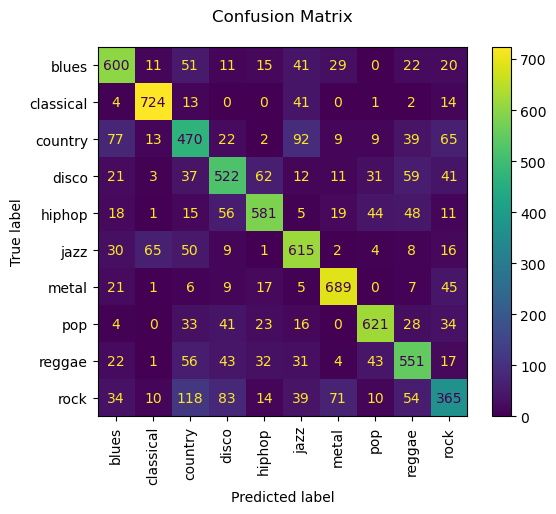

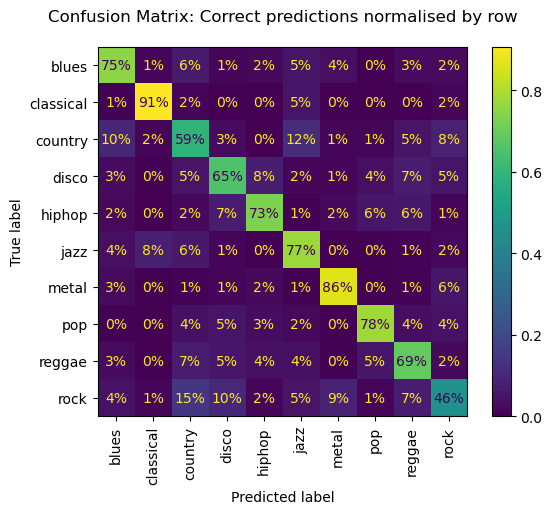

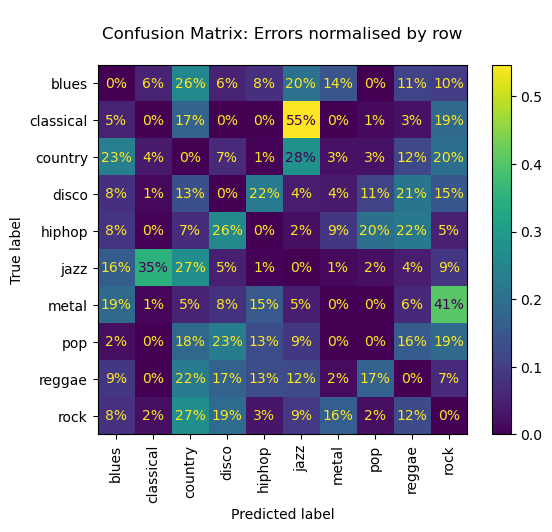

In [57]:
# cross-validate and return predictions for X_train over 5 folds
y_pred_randfor = cross_val_predict(rand_for, X_train, y_train, cv=5)

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_train, y_pred_randfor))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_randfor,
                                       xticks_rotation='vertical')
plt.title("Confusion Matrix\n")
plt.show()

# Confusion Matrix with percentages of images classified correctly
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_randfor,
                                       normalize="true",values_format=".0%",
                                       xticks_rotation='vertical')
plt.title("Confusion Matrix: Correct predictions normalised by row\n")
plt.show()

# Confusion Matrix with percentages of images classified incorrectly
sample_weight = (y_pred_randfor != y_train) # put zero weight on correct predictions
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_randfor,
                                        sample_weight=sample_weight,
                                        normalize="true",values_format=".0%",
                                        xticks_rotation='vertical')
plt.title("\nConfusion Matrix: Errors normalised by row\n")
plt.show()

### K-Nearest Neighbour (KNN)

In [58]:
# Train a KNN Classifier model using the default settings

knn = make_pipeline(preprocessing, KNeighborsClassifier()) 
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scal',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['chroma_stft_mean',
                                                   'mfcc4_mean',
                                                   'mfcc1_mean']),
                                                 ('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x00000236C0446FC0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['perceptr_var', 'rms_var',
                                                   'mfcc1_var',
                                                   'rolloff_var']),
                                                 ('log2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function <lambda> at 0x00000236C0446F20>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['spectral_bandwidth_mean'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [166]:
# Compare predicted classes against actual classes in the KNN model
y_10_predictions = knn.predict(X_train_sampled)
y_train_10_actual_classes = y_train.loc[y_train.index.isin(sampled_rows_idx)]

# print actual classes / predictions in the 10 sampled instances
for i, prediction in enumerate(y_10_predictions, start=0):    
    print(f"Actual: {y_train_10_actual_classes.iloc[i]:<10} Predicted: {prediction}")

Actual: hiphop     Predicted: disco
Actual: metal      Predicted: metal
Actual: rock       Predicted: rock
Actual: blues      Predicted: blues
Actual: jazz       Predicted: jazz
Actual: disco      Predicted: disco
Actual: classical  Predicted: classical
Actual: reggae     Predicted: reggae
Actual: country    Predicted: country
Actual: pop        Predicted: reggae


Classification Report:
               precision    recall  f1-score   support

       blues       0.62      0.73      0.67       800
   classical       0.86      0.92      0.89       799
     country       0.51      0.57      0.53       798
       disco       0.59      0.67      0.63       799
      hiphop       0.75      0.69      0.72       798
        jazz       0.70      0.68      0.69       800
       metal       0.83      0.82      0.82       800
         pop       0.80      0.74      0.77       800
      reggae       0.66      0.69      0.67       800
        rock       0.57      0.37      0.45       798

    accuracy                           0.69      7992
   macro avg       0.69      0.69      0.68      7992
weighted avg       0.69      0.69      0.68      7992



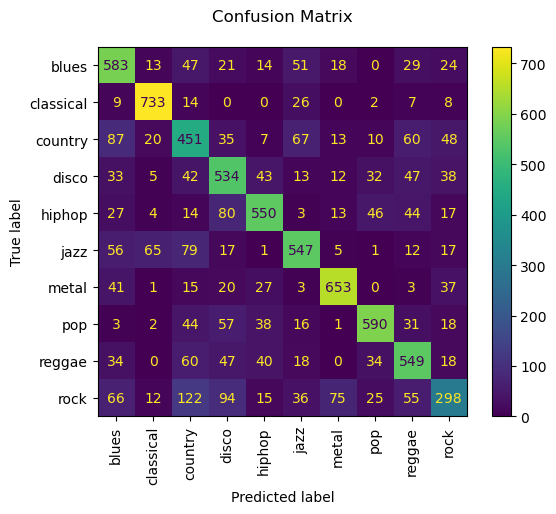

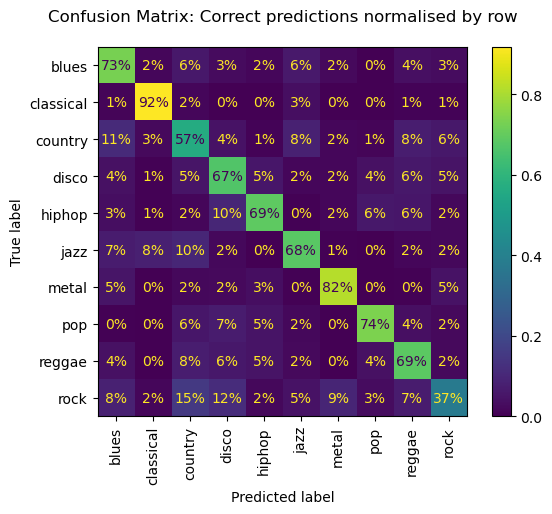

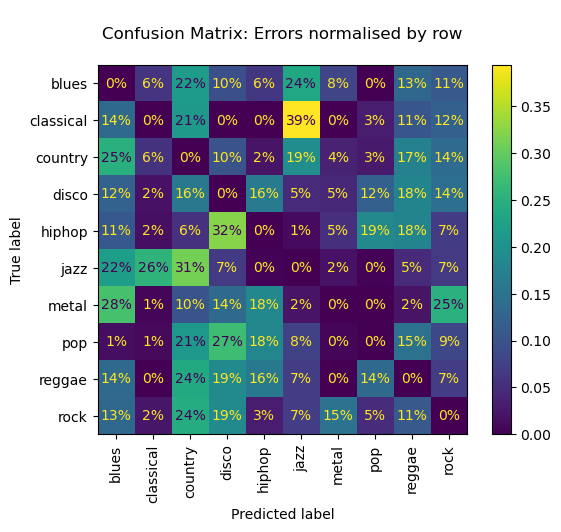

In [59]:
# cross-validate and return predictions for X_train over 5 folds
y_pred_knn = cross_val_predict(knn, X_train, y_train, cv=5)

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_train, y_pred_knn))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_knn,
                                       xticks_rotation='vertical')
plt.title("Confusion Matrix\n")
plt.show()

# Confusion Matrix with percentages of images classified correctly
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_knn,
                                       normalize="true",values_format=".0%",
                                       xticks_rotation='vertical')
plt.title("Confusion Matrix: Correct predictions normalised by row\n")
plt.show()

# Confusion Matrix with percentages of images classified incorrectly
sample_weight = (y_pred_knn != y_train) # put zero weight on correct predictions
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_knn,
                                        sample_weight=sample_weight,
                                        normalize="true",values_format=".0%",
                                        xticks_rotation='vertical')
plt.title("\nConfusion Matrix: Errors normalised by row\n")
plt.show()

## Fine-tuning the Models

### Logistic Regression

In [60]:
# Manually explore the optimal C hyperparameter setting

C_values = [0.001, 0.01, 1, 10, 100, 1000]  # Values of C to compare

# Collect accuracy scores for tried C_value
train_accuracies = []
cv_accuracies = []


for C_value in C_values:
    # construct temporary pipeline with tried C_value setting
    C_search_model = make_pipeline(preprocessing, LogisticRegression(C=C_value, max_iter=100))

    # get training predictions and cross-validation predictions 
    C_search_model.fit(X_train, y_train)
    y_pred = C_search_model.predict(X_train)
    y_cv_pred = cross_val_predict(C_search_model, X_train, y_train, cv=3)                               

    # calculate and collect accuracy scores
    train_accuracy = accuracy_score(y_train, y_pred)
    cv_accuracy = accuracy_score(y_train, y_cv_pred)
    train_accuracies.append(train_accuracy)
    cv_accuracies.append(cv_accuracy)

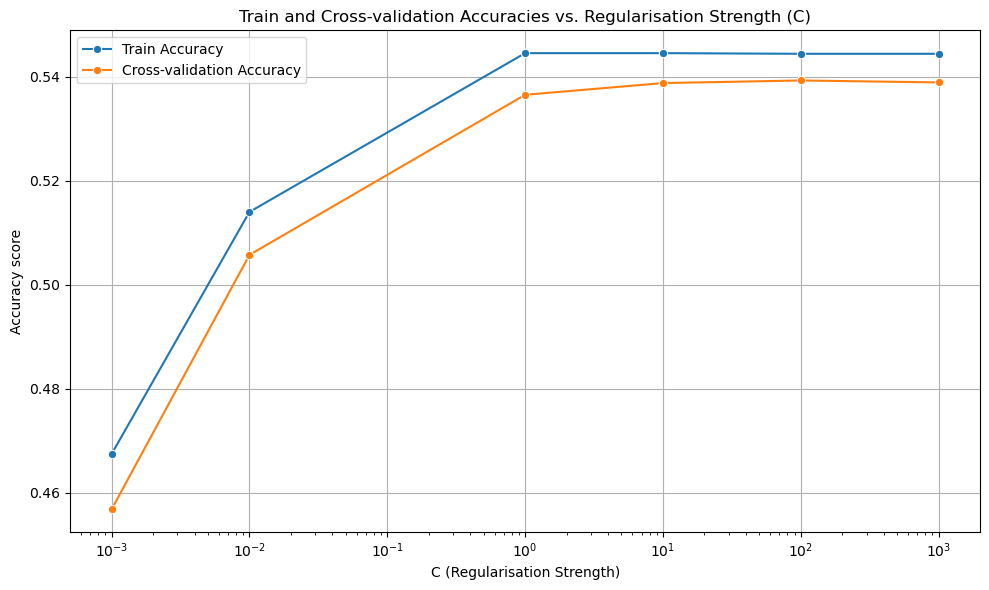

In [61]:
# plot cross-validation accuracy scores for different C_values

plt.figure(figsize=(10, 6))
sns.lineplot(x=C_values, y=train_accuracies, label='Train Accuracy', marker='o')
sns.lineplot(x=C_values, y=cv_accuracies, label='Cross-validation Accuracy', marker='o')
plt.xscale('log')  # Use a logarithmic scale for C
plt.title('Train and Cross-validation Accuracies vs. Regularisation Strength (C)')
plt.xlabel('C (Regularisation Strength)')
plt.ylabel('Accuracy score')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# write-up: the optimal C_value influencing the strength of regularisation is 100 according to the search